In [2]:
!pip install torch torchvision pytorch_lightning joblib opencv-python natsort

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 31.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 890.6/890.6 kB 45.5 MB/s eta 0:00:00


In [3]:
%load_ext autoreload
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import joblib

from PIL import *
import cv2

import time
import math
import sys
import os

import torch
from torch import nn
from torch.optim import SGD
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.ops import box_iou
import pytorch_lightning as pl
from tqdm.cli import tqdm as tq

from statistics import mean
from typing import Tuple, Dict, Iterable

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# Get the absolute path of your Google Drive directory
google_drive_path = '/content/drive/MyDrive/Colab Notebooks/Topics' # Replace with the actual path

# Add the Google Drive path to the Python path
sys.path.append(google_drive_path)

os.chdir('/content/drive/MyDrive/Colab Notebooks/Topics')

In [6]:
autoreload 2

In [7]:
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 200

In [8]:
from torchvision.models.detection import maskrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

In [9]:
model = maskrcnn_resnet50_fpn(
    pretrained = True,
)

# Change number of output classes to two ( no-crater, crater )
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor( in_features, num_classes = 2 )

param_size = 0
for param in model.parameters():
    param_size += param.nelement() * param.element_size()
buffer_size = 0
for buffer in model.buffers():
    buffer_size += buffer.nelement() * buffer.element_size()

size_all_mb = ( param_size + buffer_size ) / (1728 * 2352)
print('model size: {:.3f}MB'.format(size_all_mb))

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth
100%|██████████| 170M/170M [00:00<00:00, 218MB/s]


model size: 43.355MB


In [10]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [11]:
path = "training_checkpoints/mask_rcnn_8.blob"
model.load_state_dict( torch.load( path ) )
model.eval()
model.to( device )
print( 'Loaded:', path )

<ipython-input-11-054c51827e9f>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict( torch.load( path ) )


Loaded: training_checkpoints/mask_rcnn_8.blob


In [12]:
craters = []

# Iterate through each file in the directory
for filename in os.listdir('CH5-png') :
    craters.append(filename)

In [13]:
# Build CDA database (typically takes about a minute)
from change_dataset_mask import CraterDataset
image_width = 2352
image_height = 1728
cd = CraterDataset( craters, ( image_height, image_width ) )

Filter bad samples:
Total Images after Filtering 42


In [14]:
# Return the batch as an iterable, skipping 'None' samples
def collate_fn(batch: Iterable):
    return tuple( zip( *( filter( lambda x:x is not None, batch ) ) ) )

In [15]:
# Split the dataset into train and test
trainIndices, testIndices = cd.testSplit()
print( 'Training samples:', len( trainIndices ) )
print( 'Testing samples:', len( testIndices ) )

dataset_test = torch.utils.data.Subset( cd, testIndices )

data_loader_test = torch.utils.data.DataLoader(
    dataset_test,
    batch_size = 8,
    shuffle = False,
    num_workers = 16,
    collate_fn = collate_fn
)

Training samples: 0
Testing samples: 42


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [16]:
predictions = []

with torch.no_grad():
    bar = tq( data_loader_test, desc = f"Test Predictions" )

    for batch, ( images, targets_batch ) in enumerate( bar, 1 ):
        images = list( image.to( device ) for image in images )

        # Make predictions
        p = model( images )

        # Move predictions to RAM
        p = [ { k: v.to( device ) for k, v in d.items() } for d in p ]

        # Postprocess mask into ellipse parameters
        for sample in p:
            sample['ellipse_sparse'] = []

            for im in sample['masks']:
                bool_mask = im > 0.5
                bool_mask = bool_mask.squeeze()
                bool_mask = bool_mask.detach().cpu().numpy().astype(np.uint8) * 255
                contours, _ = cv2.findContours(bool_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

                if contours and len(contours[0]) >= 5:
                    largest_contour = max(contours, key=cv2.contourArea)
                    ellipse = cv2.fitEllipse(largest_contour)
                    (x, y), (a, b), theta = ellipse
                    theta = np.radians(theta)

                    # Adjust theta as per your logic
                    if theta > np.pi / 2:
                        theta -= np.pi
                    elif theta < -np.pi / 2:
                        theta += np.pi
                    # print(f"Ellipse fitted: {samples['ellipse_sparse'][-1]}")

                sample['ellipse_sparse'].append([x, y, a / 2, b / 2, theta])

        predictions.extend( p )

Test Predictions: 100%|██████████| 6/6 [00:33<00:00,  5.59s/it]


In [17]:
targets = []

with torch.no_grad():
    bar = tq( data_loader_test, desc = f"Test Predictions" )

    for batch, ( images, targets_batch ) in enumerate( bar, 1 ):
        # targets_batch = [ { k: v.to( torch.device( 'cpu' ) ) for k, v in d.items() } for d in targets_batch ]

        # Delete masks from target to save memory
        for t in targets_batch:
            del t['masks']

        targets.extend( targets_batch )

Test Predictions: 100%|██████████| 6/6 [00:26<00:00,  4.42s/it]


In [61]:
from joblib import dump
dump( { 'targets': targets, 'predictions': predictions }, 'Mask-Sim-Test2' )

['Mask-Sim-Test2']

dict_keys(['boxes', 'labels', 'scores', 'masks', 'ellipse_sparse'])


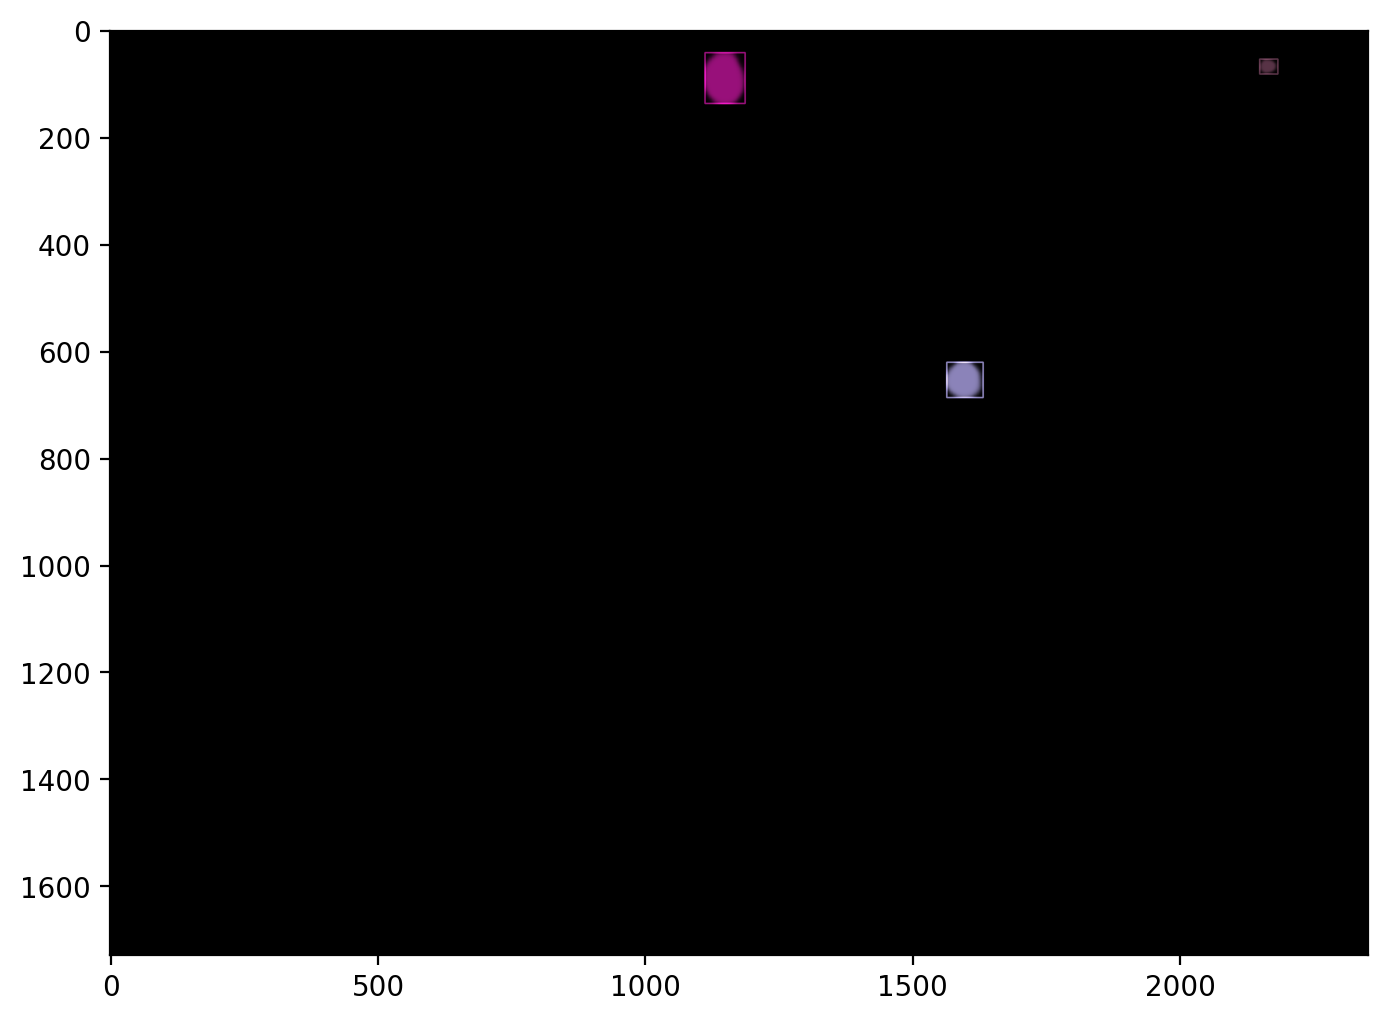

In [62]:
img = np.zeros( ( image_height, image_width, 3 ) )
print (p[0].keys())
for bbox, mask in zip( p[0]['boxes'].cpu().numpy(), p[0]['masks'].cpu().numpy() ):
    color = ( np.random.rand(), np.random.rand(), np.random.rand() )

    # Plot bounding box:
    cv2.rectangle(
        img,
        ( int( bbox[0] ), int( bbox[1] ) ),
        ( int( bbox[2] ), int( bbox[3] ) ),
        color,
        2,
    )

    # Apply color to mask
    mask = cv2.merge( ( mask * color[0], mask * color[1], mask * color[2] ) )

    img[:,:,:] += mask[0]
plt.imshow( img )
plt.show()

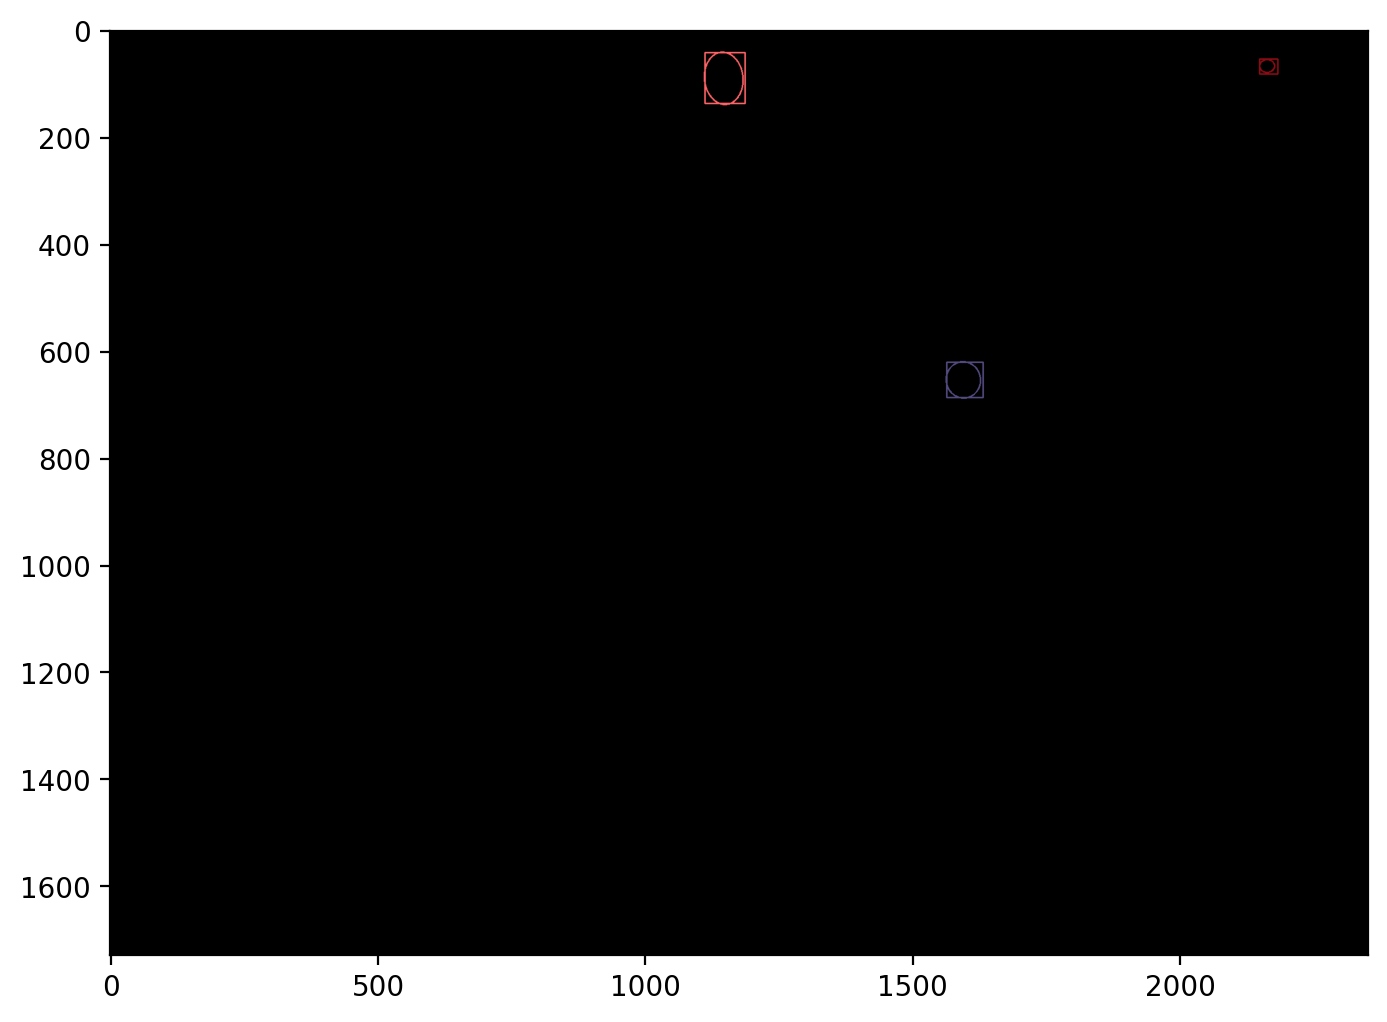

In [63]:
img = np.zeros( ( image_height, image_width, 3 ) )

index = 0

for bbox, ellipse in zip( p[index]['boxes'].cpu().numpy(), p[index]['ellipse_sparse'] ):
    color = ( np.random.rand(), np.random.rand(), np.random.rand() )

    # Plot bounding box:
    cv2.rectangle(
        img,
        ( int( bbox[0] ), int( bbox[1] ) ),
        ( int( bbox[2] ), int( bbox[3] ) ),
        color,
        2,
    )

    cv2.ellipse(
        img,
        ( int( ellipse[0] ), int( ellipse[1]) ), # Center point
        ( int( ellipse[2] ), int( ellipse[3] ) ), # Major and minor axes
        np.degrees(ellipse[4]), # Convert angle from radians to degrees
        0, # Start Angle for drawing
        360, # End Angle for drawing
        color,
        2,
    )

plt.imshow( img )
plt.show()

In [64]:
print( len( p[index]['boxes'].cpu().numpy() ))
print( len( p[index]['masks'].cpu().numpy() ))

3
3


In [18]:
targets = []

with torch.no_grad():
    bar = tq( data_loader_test, desc = f"Test Predictions" )

    for batch, ( images, targets_batch ) in enumerate( bar, 1 ):
        targets_batch = [
            {
                'boxes': t['boxes'].to(device) if 'boxes' in t else None,
                'labels': t['labels'].to(device) if 'labels' in t else None,
                'masks': t['masks'].to(device) if 'masks' in t else None,
                'ellipse_sparse': t['ellipse_sparse'].to(device) if 'ellipse_sparse' in t else None,
            }
            for t in targets_batch
        ]
        # Delete masks from target to save memory
        for t in targets_batch:
            del t['masks']

        targets.extend( targets_batch )

Test Predictions: 100%|██████████| 6/6 [00:28<00:00,  4.73s/it]


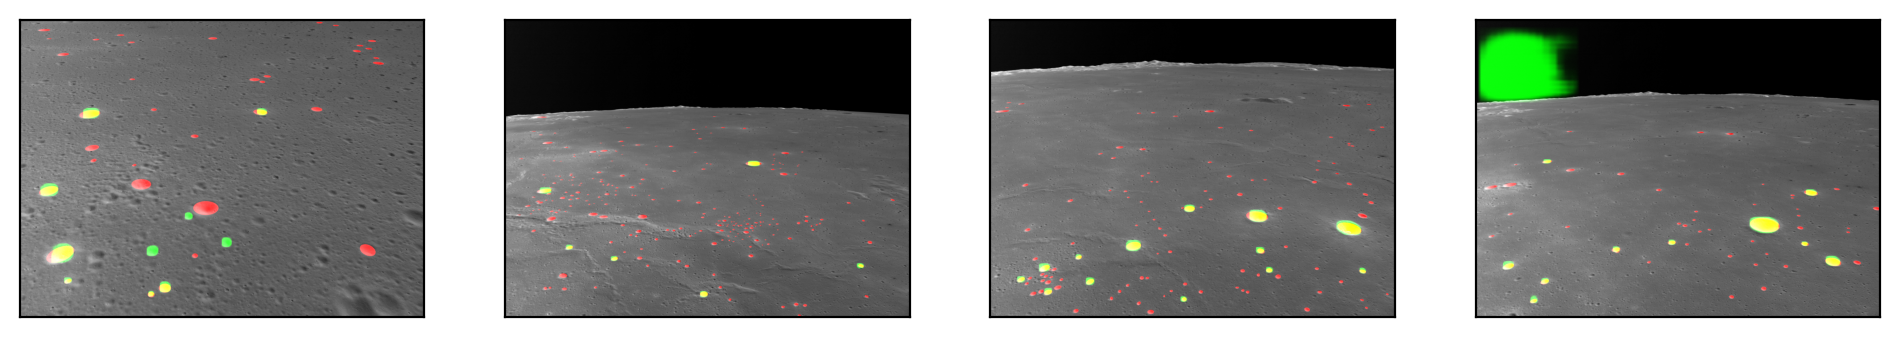

In [19]:
# Show a random sample of images
n_samples = 4
fig, ax = plt.subplots( ncols = n_samples )

for i in range( n_samples ):
    pred_index = int( np.random.rand() * len( predictions ) )
    img, target = dataset_test.__getitem__( pred_index )
    img = img.numpy()[0]
    img = np.stack( ( img, img, img ), axis = 2 )
    for mask in target['masks']:
        img[:,:,0] += mask.numpy()

    for mask in predictions[pred_index]['masks']:
        img[:,:,1] += mask.cpu().numpy()[0]

    # Red is False Negative
    # Green is False Positive
    # Yellow is True Positive

    ax[i].imshow( img )
    ax[i].set_xticks( [] )
    ax[i].set_yticks( [] )
    # ax[i].set_title( 'Angle: {angle:d}, Sample: {sample:d}'.format( angle = target['view_angle'][0].item(), sample = target['image_id'].item() ) )
plt.show()

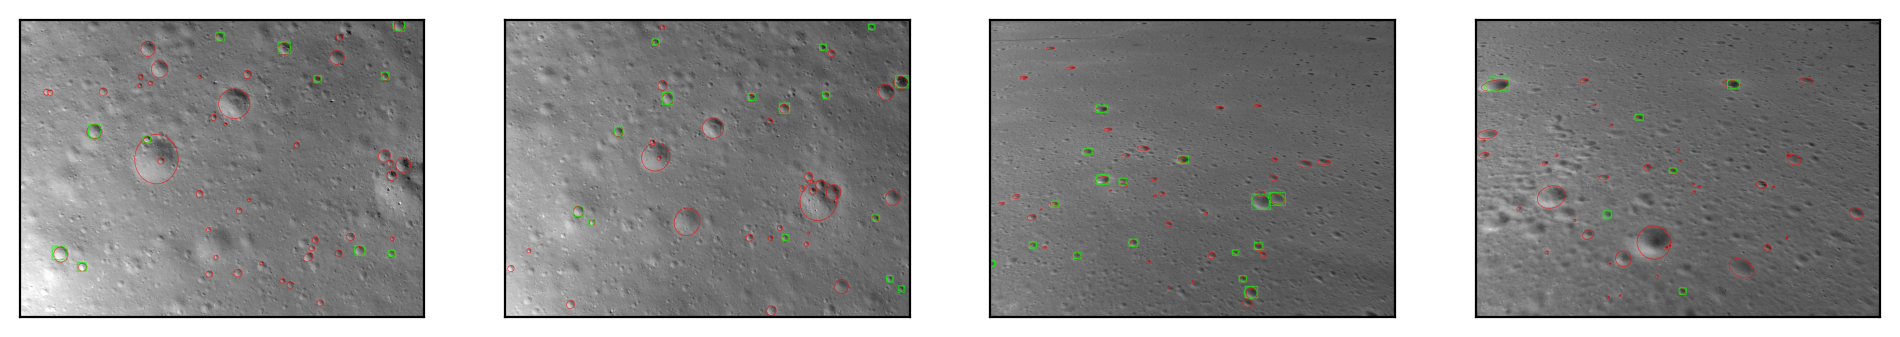

In [42]:
# Show a random sample of images
n_samples = 4
fig, ax = plt.subplots( ncols = n_samples )

for i in range( n_samples ):
    pred_index = int( np.random.rand() * len( predictions ) )
    img, target = dataset_test.__getitem__( pred_index )
    img = img.numpy()[0]
    img = np.stack( ( img, img, img ), axis = 2 )

    color = ( 1, 0, 0 )
    for ellipse in target['ellipse_sparse']:
        # Plot ellipse:
        cv2.ellipse(
            img,
            ( int( ellipse[0] ), int( ellipse[1] ) ), # Center point
            ( int( ellipse[2] ), int( ellipse[3] ) ), # Major and minor axes
            float( ellipse[4] * 180 / math.pi ), # Convert angle from radians to degrees
            0, # Start Angle for drawing
            360, # End Angle for drawing
            color,
            2,
        )

    color = ( 0, 1, 0 )
    for ellipse in predictions[pred_index]['ellipse_sparse']:
        # Plot ellipse:
        cv2.ellipse(
            img,
            ( int( ellipse[0] ), int( ellipse[1] ) ), # Center point
            ( int( ellipse[2]  ), int( ellipse[3]  ) ), # Major and minor axes
            float( ellipse[4] * 180 / math.pi ), # Convert angle from radians to degrees
            0, # Start Angle for drawing
            360, # End Angle for drawing
            color,
            2,
        )

    for bbox in predictions[pred_index]['boxes']:
        # Plot bounding box:
        cv2.rectangle(
            img,
            ( int( bbox[0] ), int( bbox[1] ) ),
            ( int( bbox[2] ), int( bbox[3] ) ),
            color,
            2,
        )

    ax[i].imshow( img )
    ax[i].set_xticks( [] )
    ax[i].set_yticks( [] )
    # ax[i].set_title( 'Angle: {angle:d}, Sample: {sample:d}'.format( angle = target['view_angle'][0].item(), sample = target['image_id'].item() ) )
plt.show()

In [20]:
results = []

for confidence_threshold in np.concatenate( ( np.arange( 0.01, 0.1, 0.01 ), np.arange( 0.1, 0.9, 0.1 ), np.arange( 0.9, 1.0, 0.01 ) ), axis = 0 ):
    confident_predictions = []
    for prediction in predictions:
        indices = ( prediction['scores'] > confidence_threshold ).nonzero().flatten()

        confident_predictions.append( {
            'boxes': prediction['boxes'][indices],
            'scores': prediction['scores'][indices],
            'labels': prediction['labels'][indices],
        } )

    for IoU_threshold in np.arange( 0.5, 1, 0.05 ):
        tp = 0
        true_boxes = 0
        pred_boxes = 0

        for pred, target in zip( confident_predictions, targets ):
            if len( target['boxes'].shape ) < 2:
                # No craters in image
                pred_boxes += pred['boxes'].shape[0]
            else:
                iou = box_iou( pred['boxes'], target['boxes'] )
                iou_masked = iou > IoU_threshold

                tp += iou_masked.any( axis = 0 ).sum()
                true_boxes += iou_masked.shape[1]
                pred_boxes += iou_masked.shape[0]

        results.append( {
            'detections_per_image': tp.item() / len( targets ),
            'confidence_threshold': confidence_threshold,
            'IoU_threshold': IoU_threshold,
            'precision': ( tp / pred_boxes ).item(),
            'recall': ( tp / true_boxes ).item()
        } )

        print( confidence_threshold, IoU_threshold, end = '\r' )

In [21]:
results = pd.DataFrame( results )
results['f1_score'] = ( 2 * results['precision'] * results['recall'] ) / ( results['precision'] + results['recall'] )

print( 'Performance where F1 score was maximised:' )
print( results.iloc[results['f1_score'].argmax()] )

display( results )

Performance where F1 score was maximised:
detections_per_image    9.761905
confidence_threshold    0.010000
IoU_threshold           0.500000
precision               0.821643
recall                  0.177106
f1_score                0.291400
Name: 0, dtype: float64


,detections_per_image,confidence_threshold,IoU_threshold,precision,recall,f1_score
0,9.761905,0.01,0.50,0.821643,0.177106,0.291400
1,9.190476,0.01,0.55,0.773547,0.166739,0.274343
2,8.119048,0.01,0.60,0.683367,0.147300,0.242360
3,7.166667,0.01,0.65,0.603206,0.130022,0.213930
4,5.547619,0.01,0.70,0.466934,0.100648,0.165601
...,...,...,...,...,...,...
265,0.690476,0.99,0.75,0.517857,0.012527,0.024462
266,0.238095,0.99,0.80,0.178571,0.004320,0.008435
267,0.119048,0.99,0.85,0.089286,0.002160,0.004218
268,0.023810,0.99,0.90,0.017857,0.000432,0.000844


In [24]:
best_confidence_threshold = 0.01

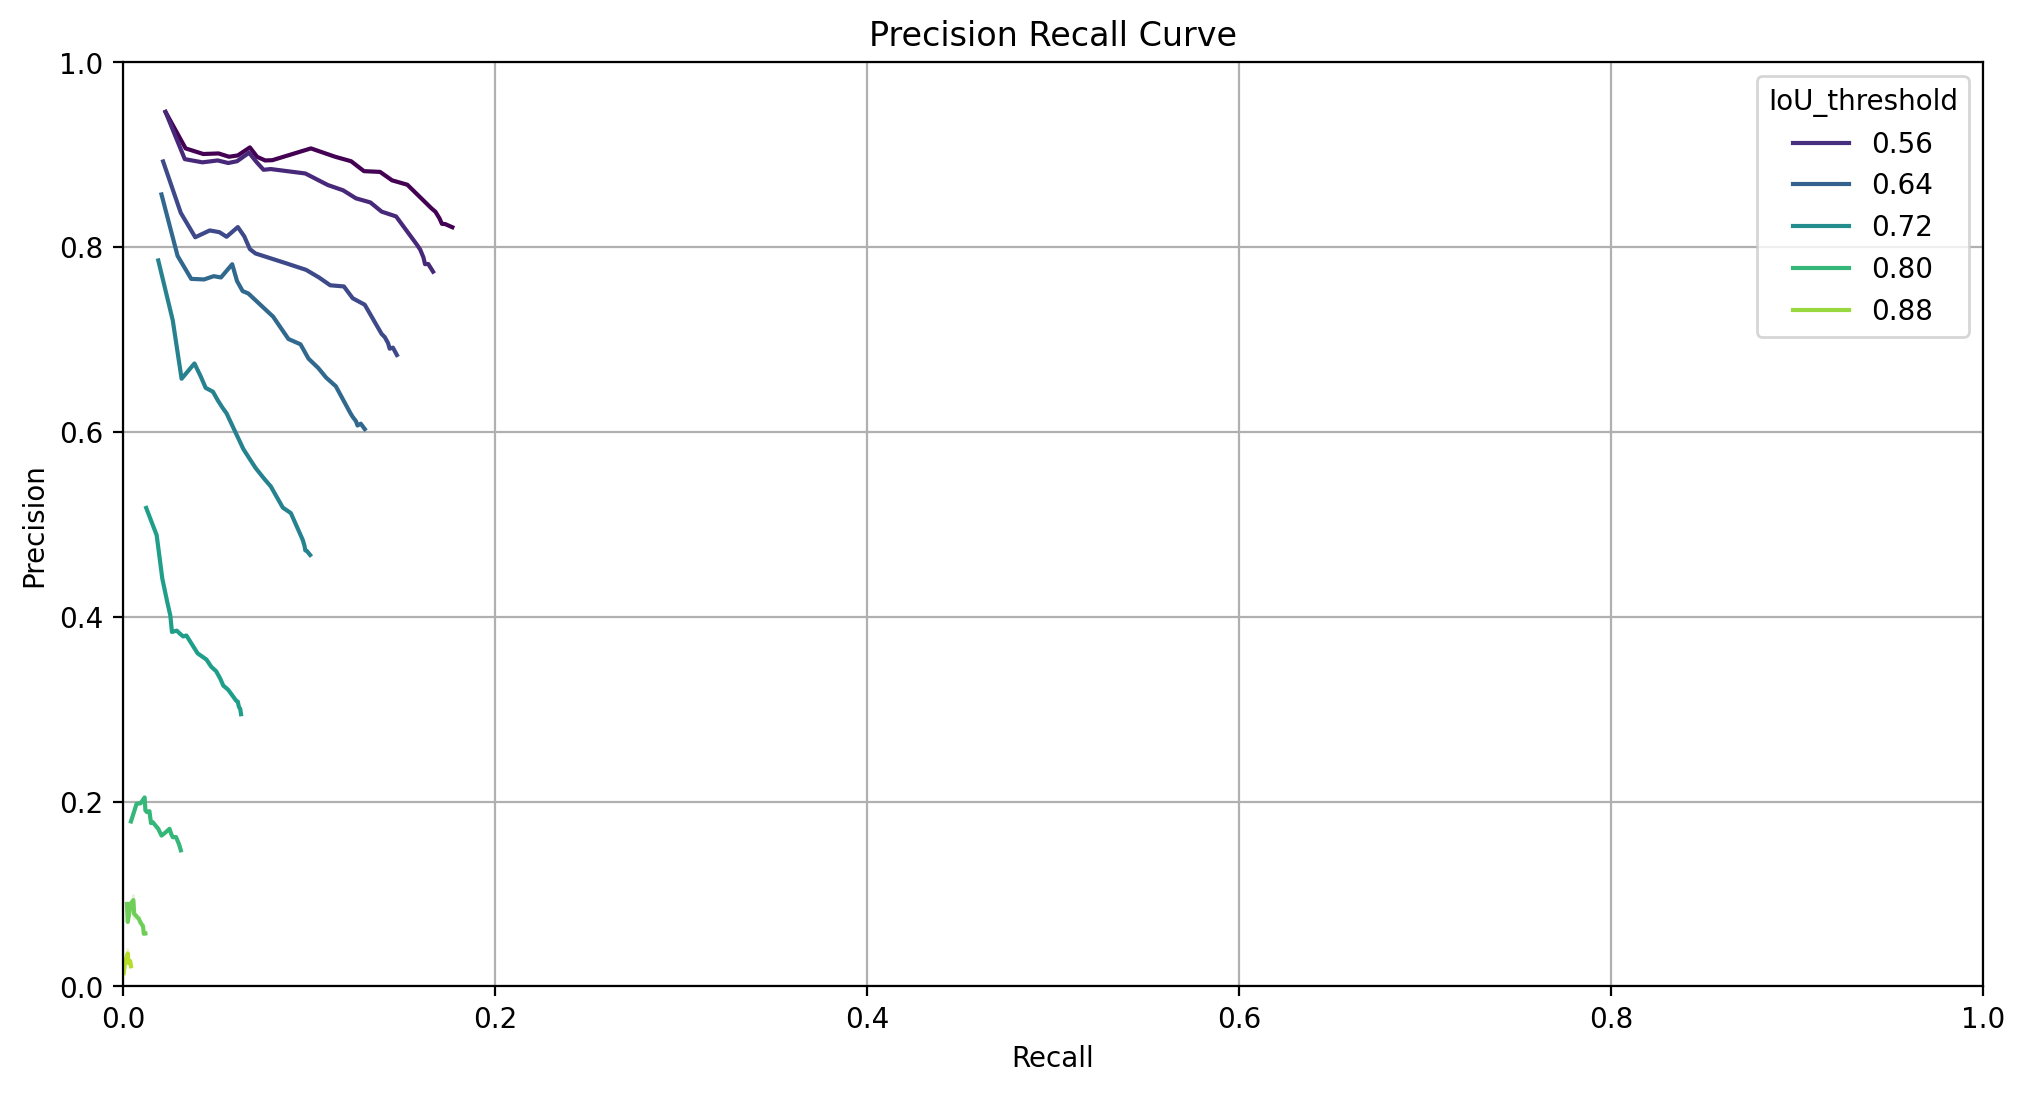

In [49]:
sns.lineplot(
    data = results,
    x = 'recall',
    y = 'precision',
    hue = 'IoU_threshold',
    # hue = 'confidence_threshold',
    palette = 'viridis',
)
plt.title( 'Precision Recall Curve')
plt.xlabel( 'Recall' )
plt.ylabel( 'Precision' )
plt.ylim( 0, 1 )
plt.xlim( 0, 1 )
plt.grid()
plt.show()

In [31]:
from change_dataset_mask import evaluate_ellipse

In [32]:
ellipse_matches = []

confidence_thresholds = [ best_confidence_threshold ]
IoU_thresholds = [ 0.5 ]

for confidence_threshold in confidence_thresholds:
    confident_predictions = []
    for prediction in predictions:
        indices = ( prediction['scores'] > confidence_threshold ).nonzero().flatten()

        # Process ellipses
        e = [prediction['ellipse_sparse'][i] for i in indices.tolist()]

        confident_predictions.append( {
            'boxes': prediction['boxes'][indices],
            'scores': prediction['scores'][indices],
            'labels': prediction['labels'][indices],
            'ellipse_sparse': e,
        } )

    for IoU_threshold in IoU_thresholds:
        tp = 0
        true_boxes = 0
        pred_boxes = 0

        for i, ( pred, target ) in enumerate( zip( confident_predictions, targets ) ):
            print( i, end = '\r' )
            if len( target['boxes'].shape ) < 2:
                # No craters in image
                pred_boxes += pred['boxes'].shape[0]
            else:
                iou = box_iou( pred['boxes'], target['boxes'] )
                iou_masked = iou > IoU_threshold
                indices = ( iou_masked == True ).nonzero( as_tuple = True )

                for pred_index, true_index in zip( indices[0], indices[1] ):
                    error = evaluate_ellipse(
                        pred['ellipse_sparse'][pred_index],
                        target['ellipse_sparse'][true_index].to( 'cpu' ).numpy()
                    )

                    ellipse_matches.append( {
                        'confidence_threshold': confidence_threshold,
                        'IoU_threshold': IoU_threshold,
                        # 'view_angle': target['view_angle'].to( 'cpu' ).numpy()[0],
                        # 'depth': target['depths'][true_index].to( 'cpu' ).numpy(),
                        'pred': pred['ellipse_sparse'][pred_index],
                        'target': target['ellipse_sparse'][true_index].to( 'cpu' ).numpy(),
                    } | error )

        print( confidence_threshold, IoU_threshold, end = '\r' )

In [33]:
ellipse_matches = pd.DataFrame( ellipse_matches )
display( ellipse_matches )

,confidence_threshold,IoU_threshold,pred,target,x_error,y_error,a_error,b_error,theta_error,absolute_error,gaussian_angle,kl_divergence,IoU
0,0.01,0.5,"[2062.586669921875, 1429.683837890625, 13.5625...","[2067.7754, 1431.0063, 16.671267, 9.983989, 0....",5.188721,1.322510,3.108706,9.816276,1.656077,21.092288,8051.414062,0.105617,0.553066
1,0.01,0.5,"[1152.868408203125, 1593.9599609375, 16.109552...","[1155.5535, 1595.8434, 23.816095, 15.479615, 0.0]",2.685059,1.883423,7.706543,7.555810,1.560550,21.391385,613.627380,0.002719,0.787651
2,0.01,0.5,"[371.3204650878906, 1322.487548828125, 12.6179...","[375.31192, 1325.6455, 20.517357, 9.558791, 6....",3.991455,3.157959,7.899384,10.169612,4.559196,29.777606,9191.086914,0.080426,0.622797
3,0.01,0.5,"[632.9853515625, 1387.553955078125, 12.5471115...","[637.81036, 1390.013, 20.4781, 10.239214, 6.07...",4.825012,2.458984,7.930988,9.356611,4.519083,29.090679,8125.718262,0.059992,0.598889
4,0.01,0.5,"[233.8297576904297, 993.5750732421875, 19.3429...","[228.90092, 996.029, 42.090096, 11.531718, 6.1...",4.928833,2.453918,22.747145,22.989644,4.647515,57.767055,5043.017090,0.246299,0.570021
...,...,...,...,...,...,...,...,...,...,...,...,...,...
406,0.01,0.5,"[357.2337951660156, 1437.0673828125, 25.384426...","[363.82605, 1438.7036, 25.213406, 23.99209, 0.0]",6.592255,1.636230,0.171021,2.680696,0.804085,11.884287,481.179688,0.008232,0.719759
407,0.01,0.5,"[432.1466369628906, 648.8939819335938, 35.9209...","[432.40973, 653.2118, 44.785294, 41.69437, 0.0]",0.263092,4.317810,8.864346,0.084049,0.114018,13.643315,62.371349,0.056326,0.745183
408,0.01,0.5,"[1158.5455322265625, 102.85433197021484, 23.48...","[1162.43, 106.28089, 25.58754, 26.07818, 0.0]",3.884521,3.426559,2.105879,0.308529,0.413219,10.138708,330.638245,0.008589,0.744867
409,0.01,0.5,"[1728.0040283203125, 345.29803466796875, 17.45...","[1724.933, 353.57944, 24.898645, 23.814793, 0.0]",3.071045,8.281403,7.440151,3.050032,0.947800,22.790431,2691.250000,0.165862,0.540484


In [27]:
predicted_ellipses = pd.DataFrame( ellipse_matches['pred'].to_list(), columns = [ 'x', 'y', 'a', 'b', 'angle' ] )
true_ellipses = pd.DataFrame( ellipse_matches['target'].to_list(), columns = [ 'x', 'y', 'a', 'b', 'angle' ] )

In [34]:
ellipse_matches['eccentricity'] = true_ellipses['b'] / true_ellipses['a']

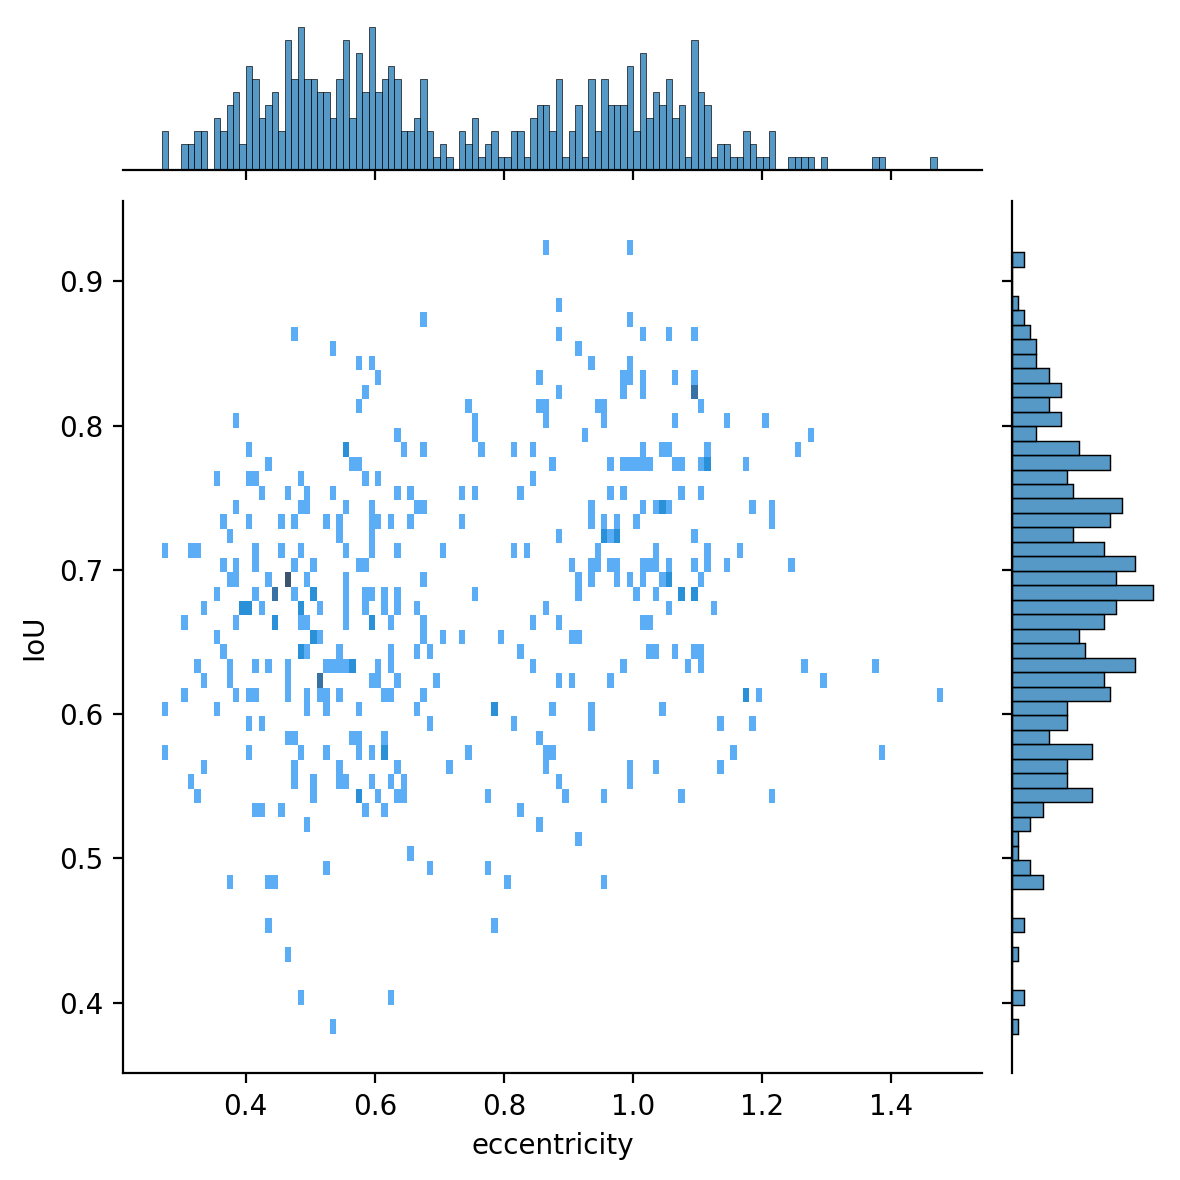

In [58]:
p = sns.jointplot(
    ellipse_matches,
    y = 'IoU',
    x = 'eccentricity',
    kind = 'hist',
    # alpha = 0.4,
    binwidth = ( 0.01, 0.01 ),
    # hue_norm = 'log',
)

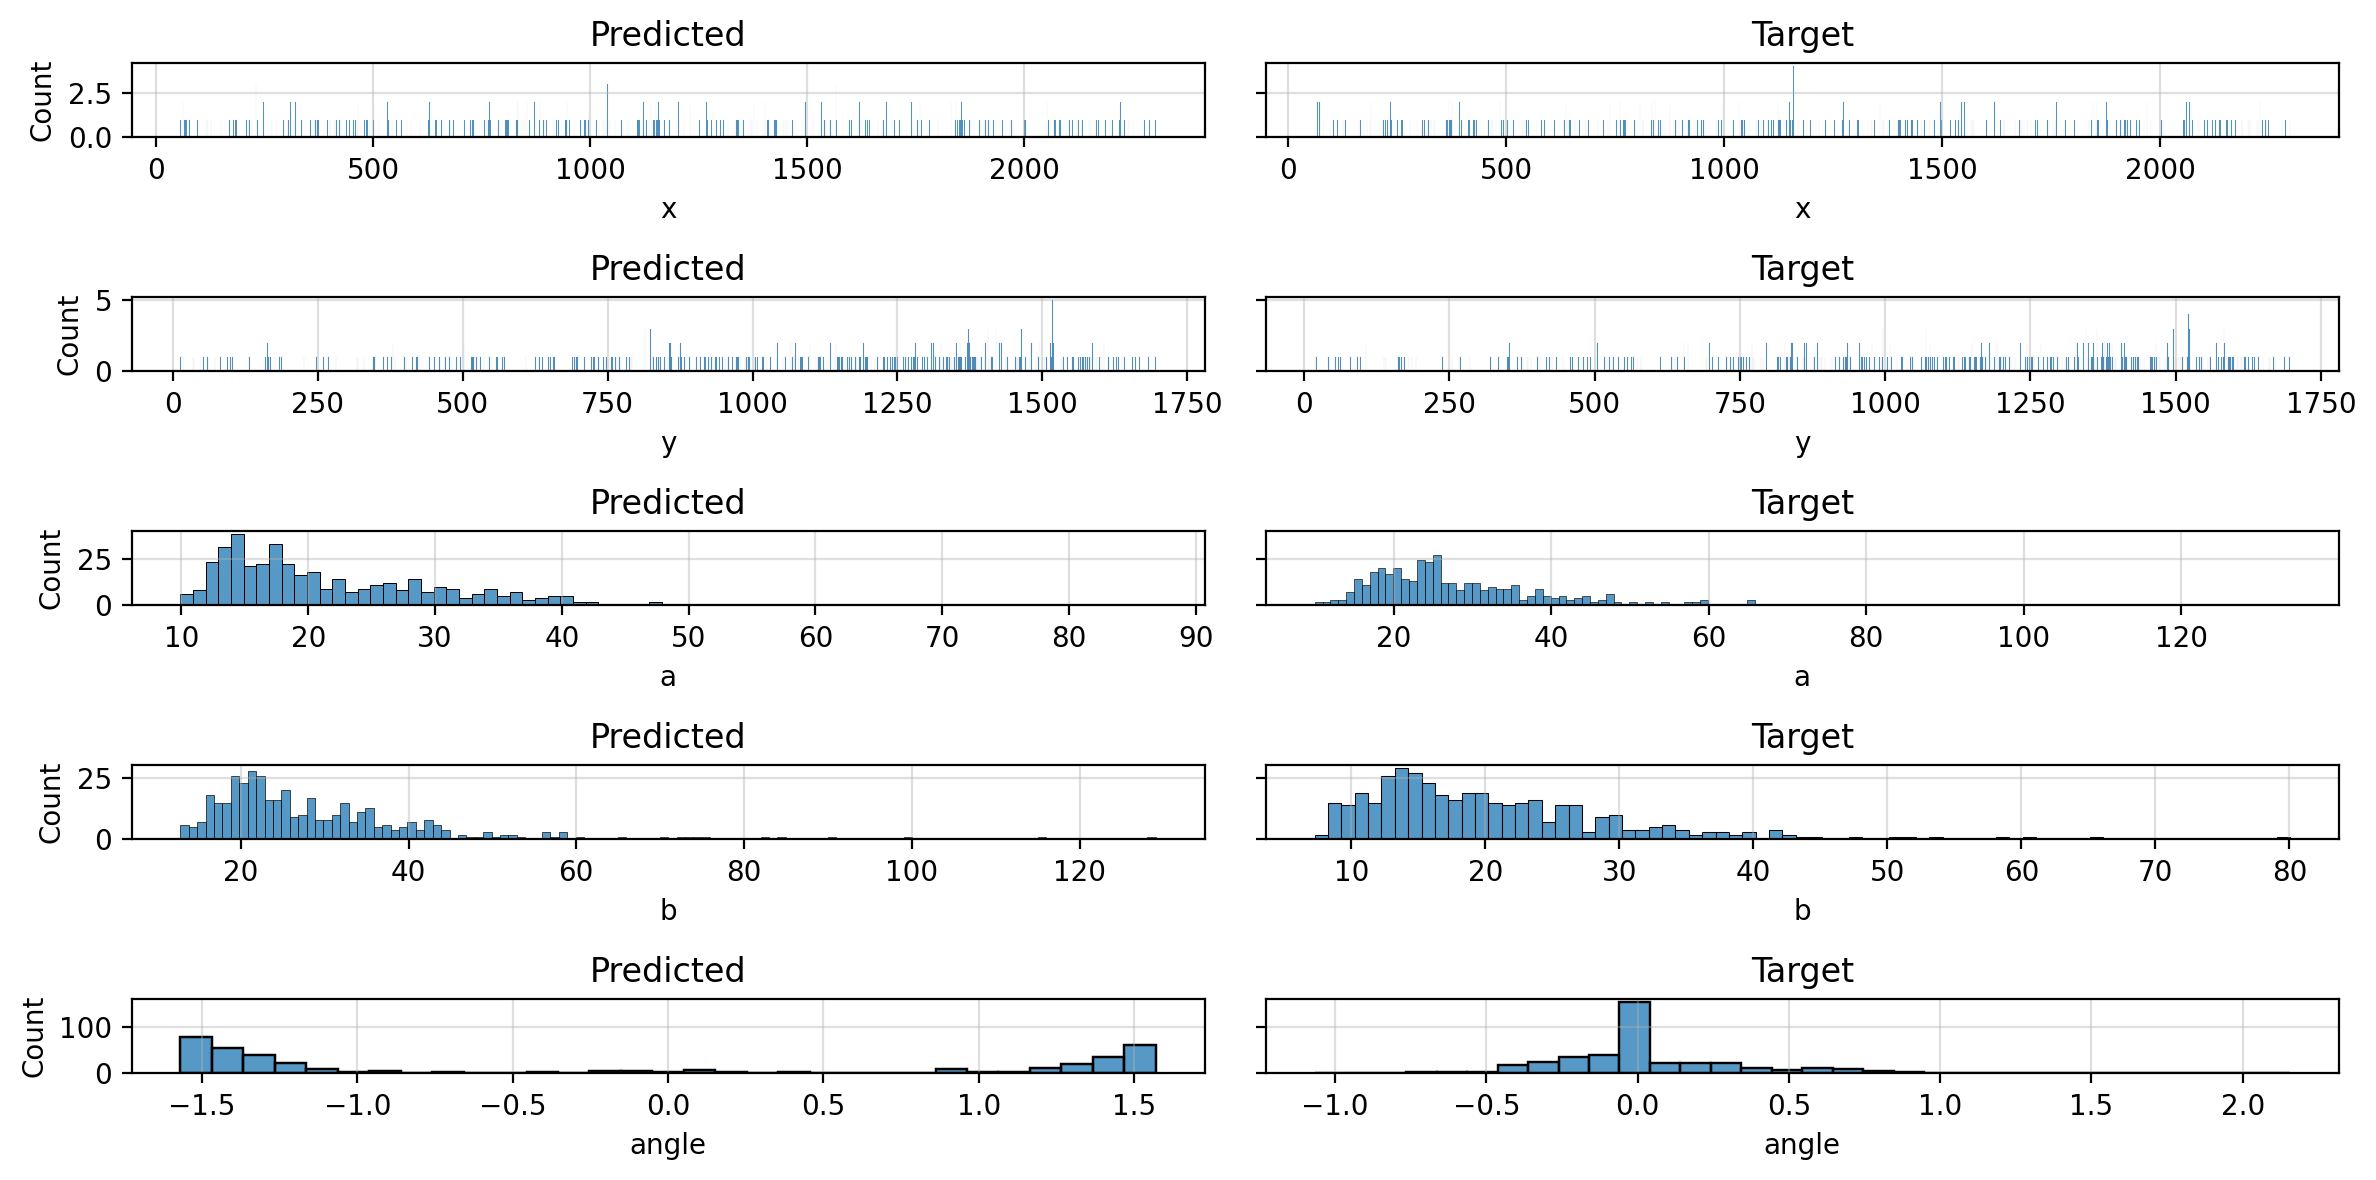

In [35]:
def wrap_angle(angle):
    # Using modulo operation to keep angle within [0, 2*pi] and shift to [-pi, pi]
    return (angle + np.pi) % (2 * np.pi) - np.pi

# Apply the wrap_angle function to the angle column of both predicted and true ellipses
predicted_ellipses['angle'] = predicted_ellipses['angle'].apply(wrap_angle)
true_ellipses['angle'] = true_ellipses['angle'].apply(wrap_angle)
# Compare distribution of predicted and target ellipses
keys = [ 'x', 'y', 'a', 'b', 'angle' ]
bin_widths = [ 1, 1, 1, 1, 0.1 ]

fig, ax = plt.subplots( nrows = len( keys ), ncols = 2, sharey = 'row', figsize = ( 12, 6 ) )

for i, key in enumerate( keys ):
    p = sns.histplot(
        data = predicted_ellipses,
        ax = ax[i,0],
        x = key,
        binwidth = bin_widths[i],
    )
    p.grid( alpha = 0.4 )
    p.set_title( 'Predicted' )
    p.set_xlabel( key )

    p = sns.histplot(
        data = true_ellipses,
        ax = ax[i,1],
        x = key,
        binwidth = bin_widths[i],
    )
    p.grid( alpha = 0.4 )
    p.set_title( 'Target' )
    p.set_xlabel( key )

fig.tight_layout()
plt.show()

In [36]:
keys = [ 'x_error', 'y_error', 'a_error', 'b_error', 'theta_error', 'absolute_error', 'IoU' ]

print( 'Average error in matched ellipses' )
for key in keys:
    print( key, ':', round( ellipse_matches[key].mean(), 3 ) )

Average error in matched ellipses
x_error : 3.084
y_error : 4.376
a_error : 8.222
b_error : 9.243
theta_error : 2.708
absolute_error : 27.632
IoU : 0.679


Index(['confidence_threshold', 'IoU_threshold', 'pred', 'target', 'x_error',
       'y_error', 'a_error', 'b_error', 'theta_error', 'absolute_error',
       'gaussian_angle', 'kl_divergence', 'IoU', 'eccentricity'],
      dtype='object')


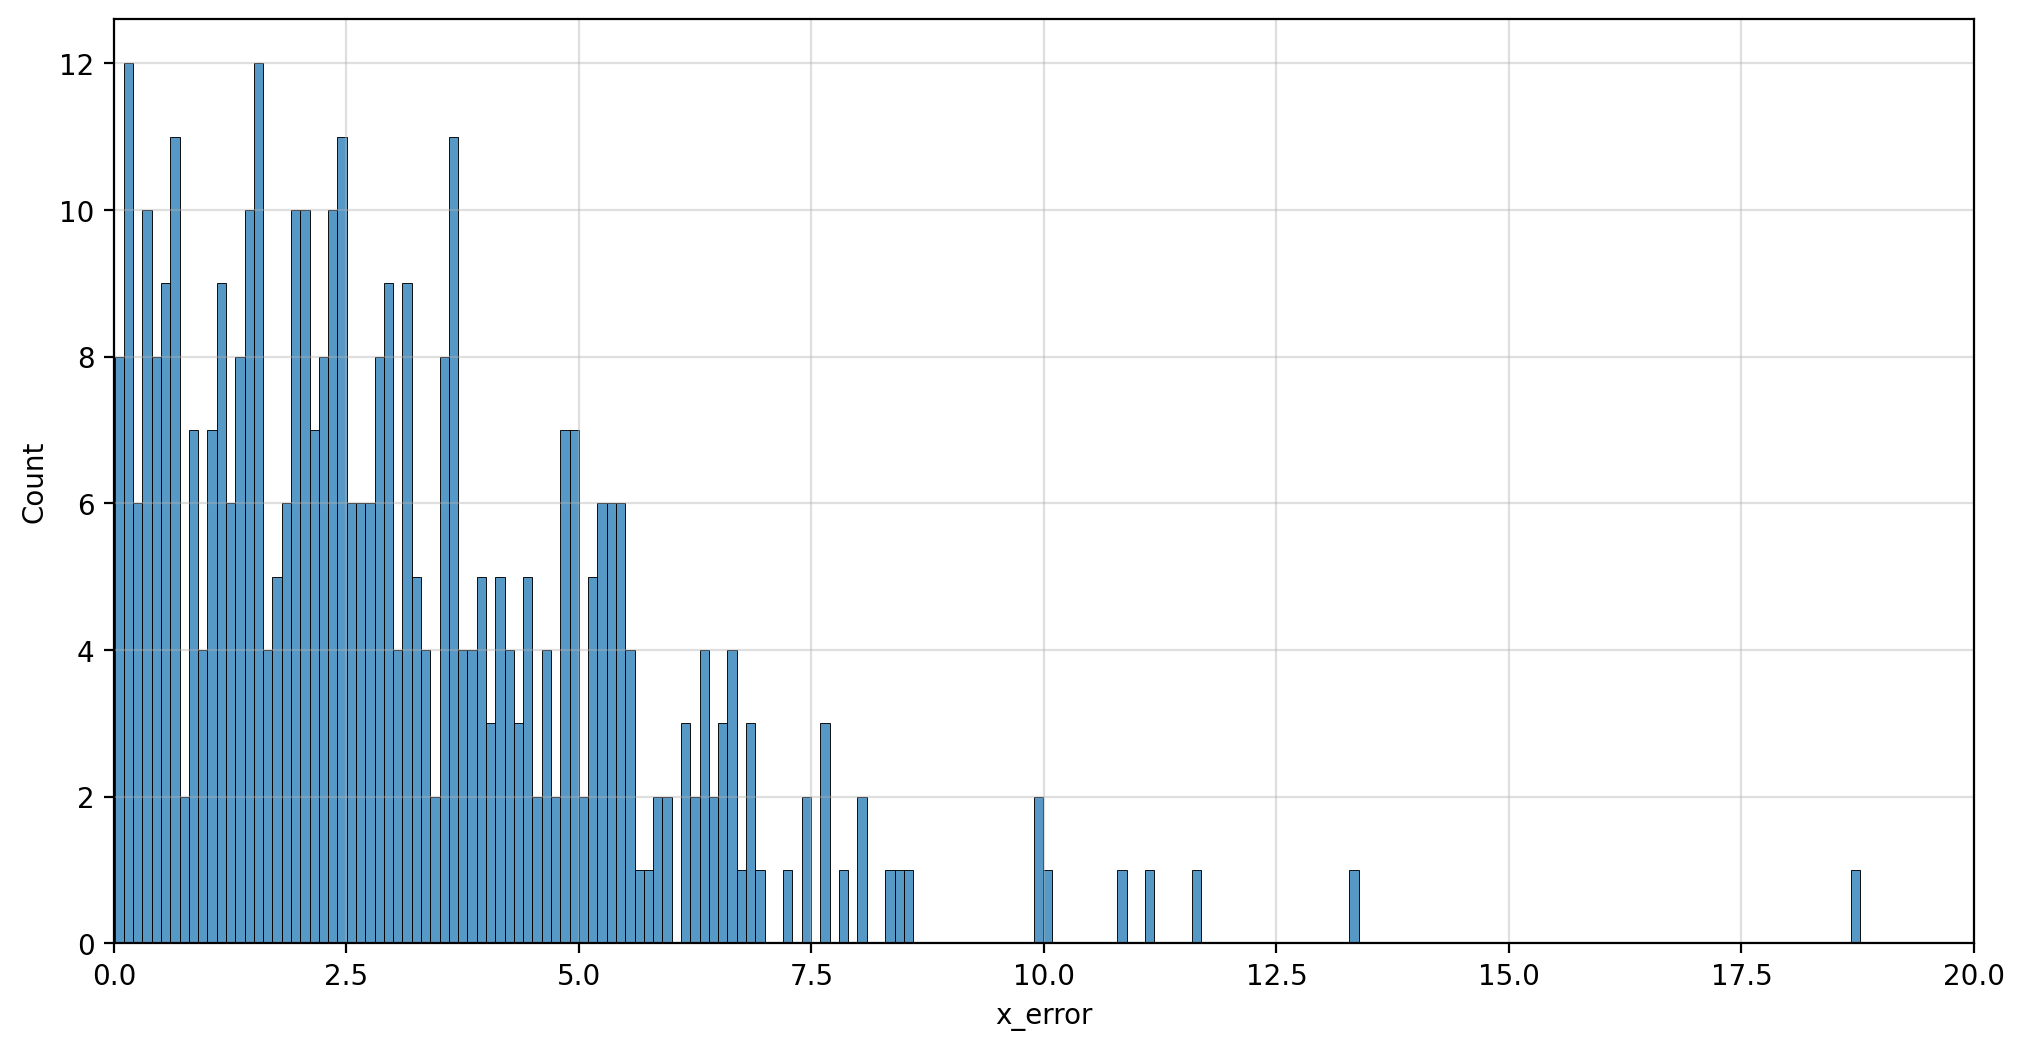

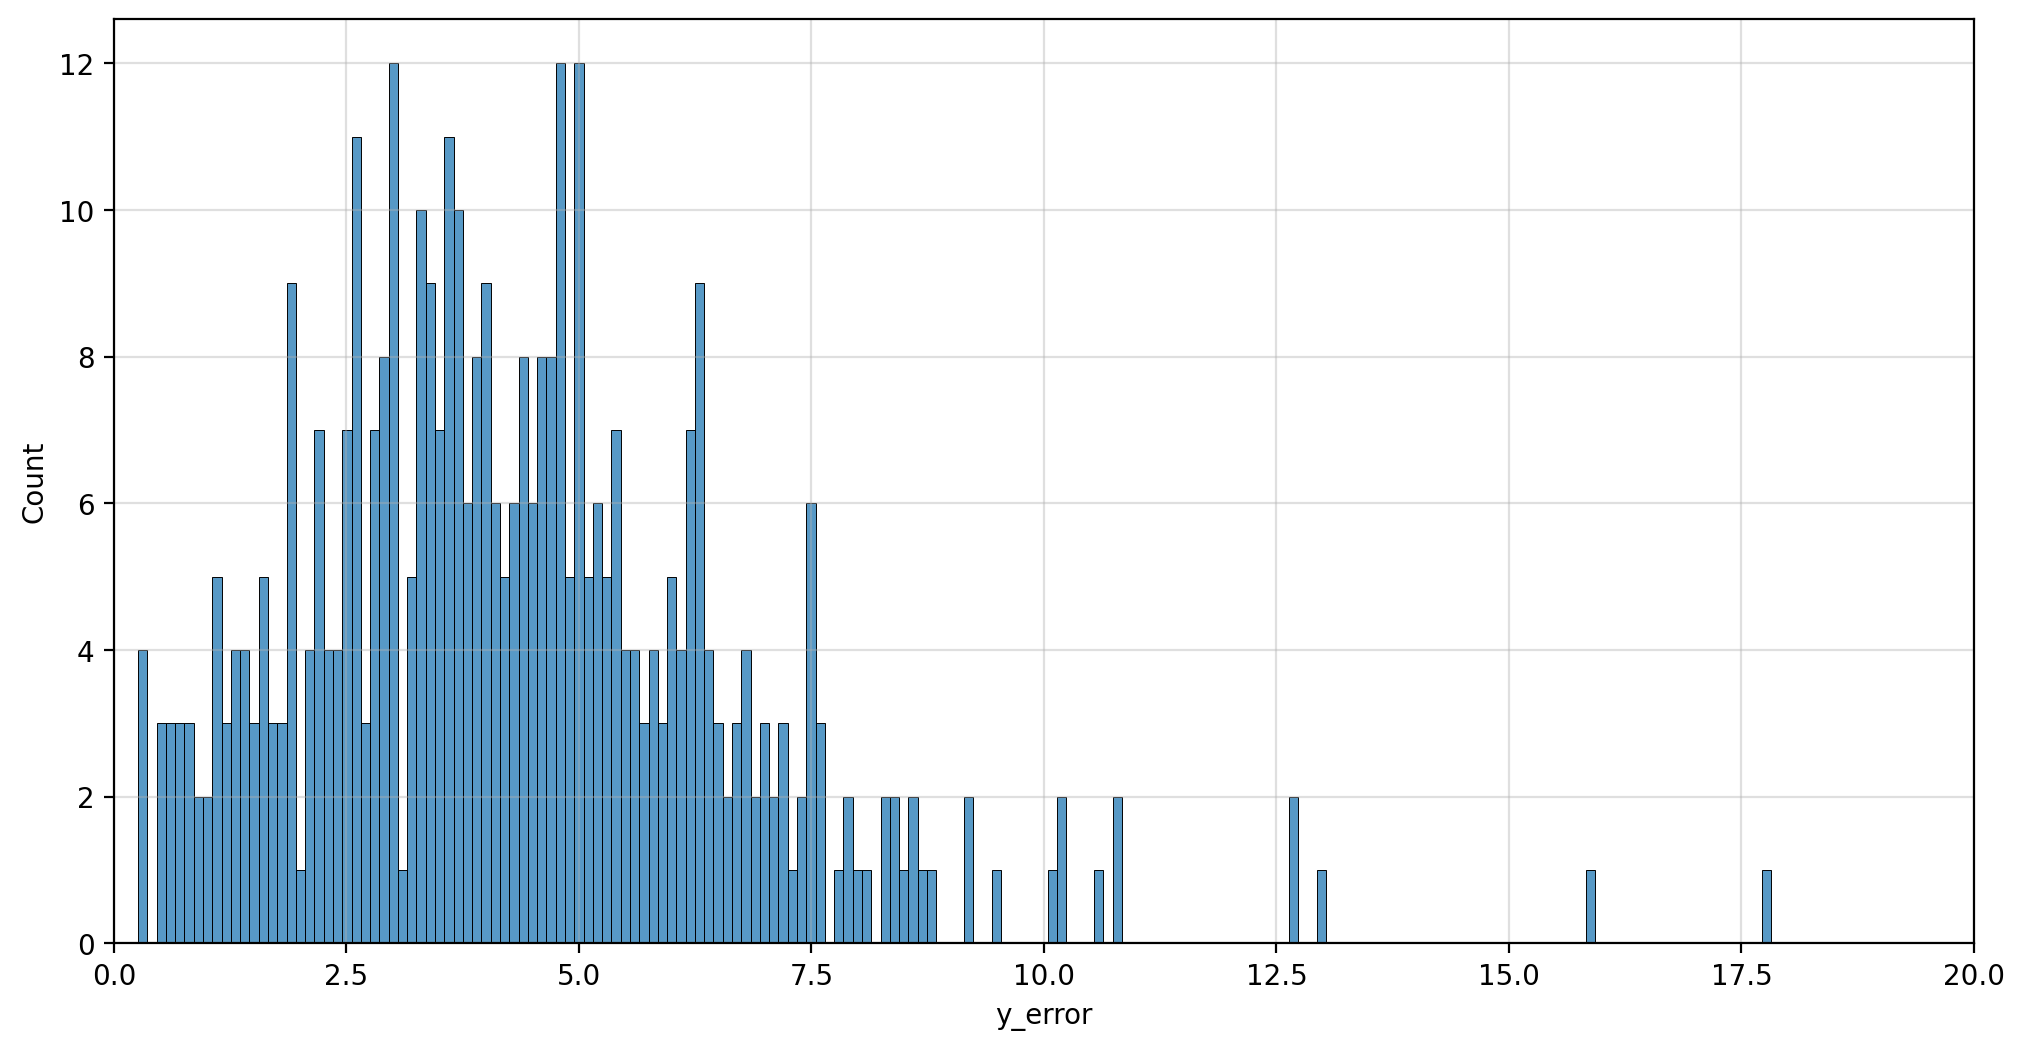

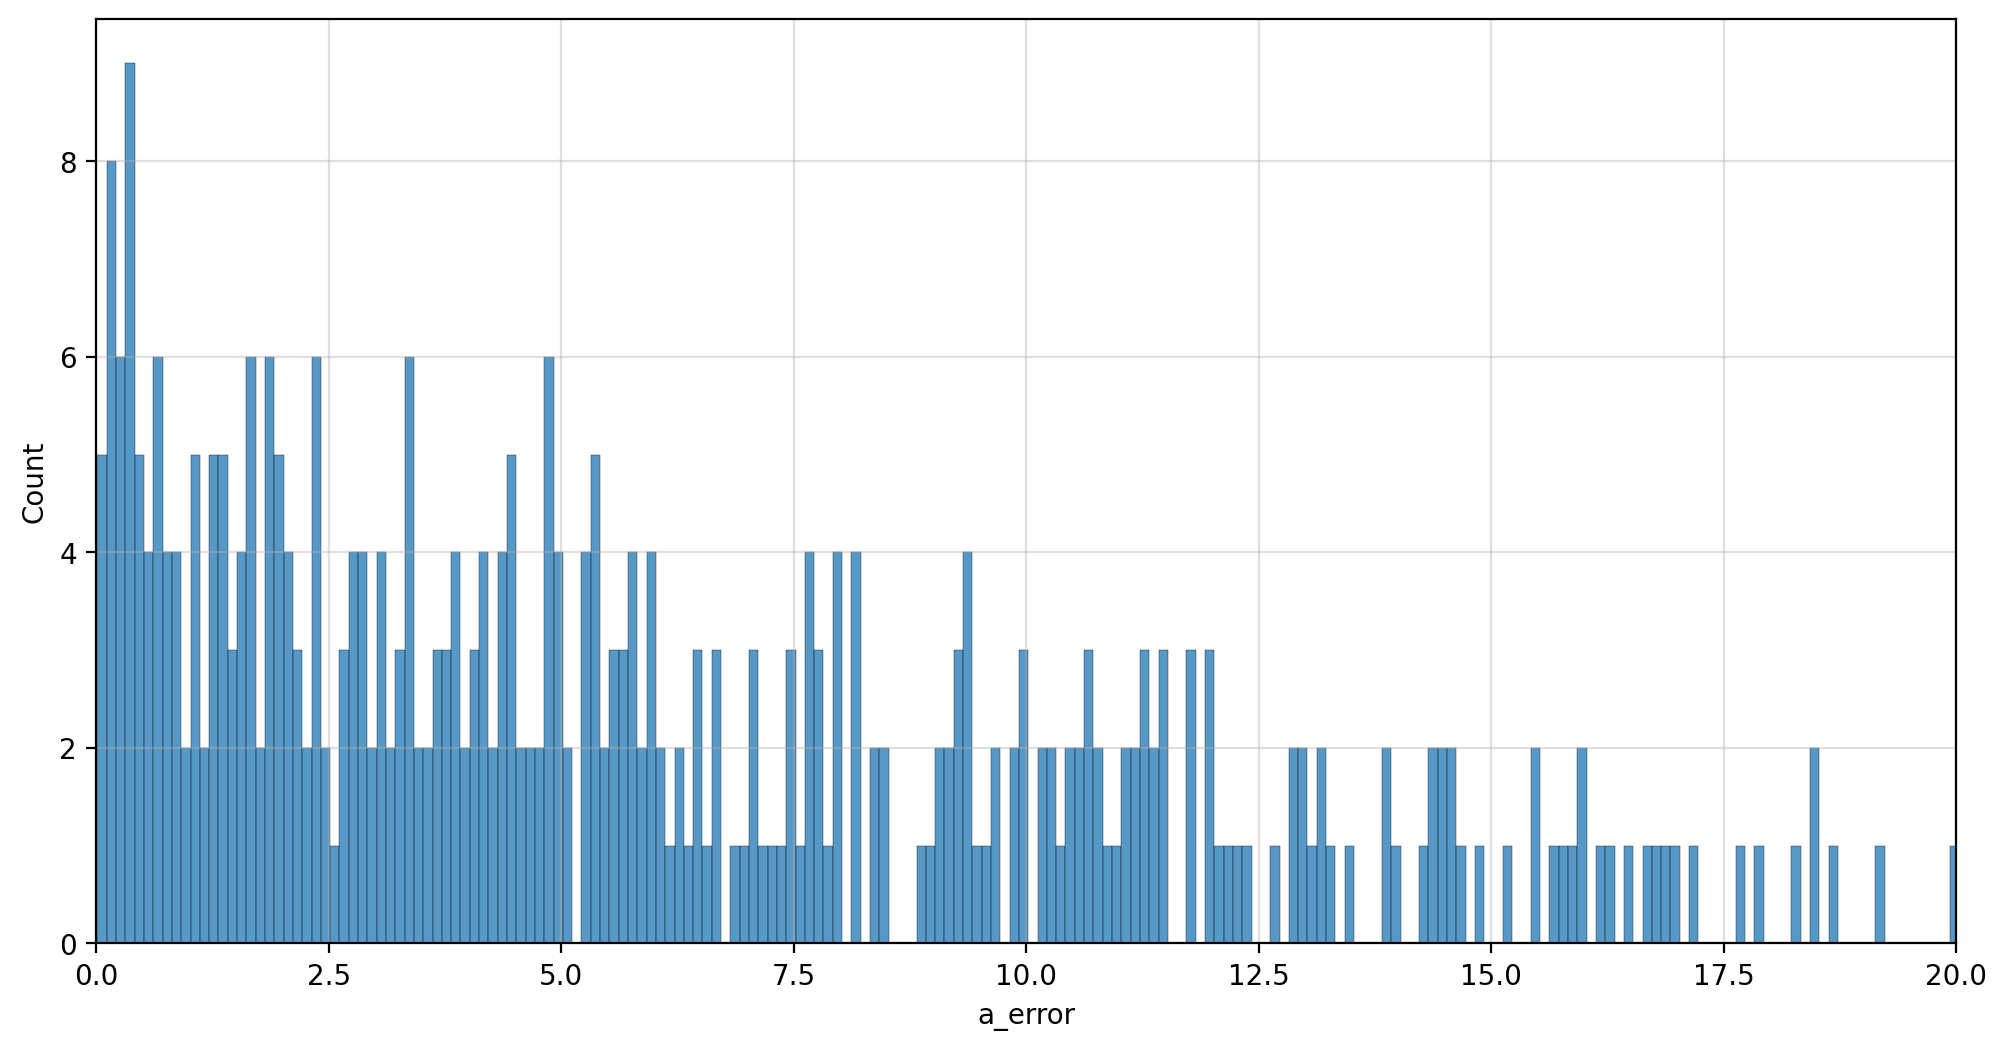

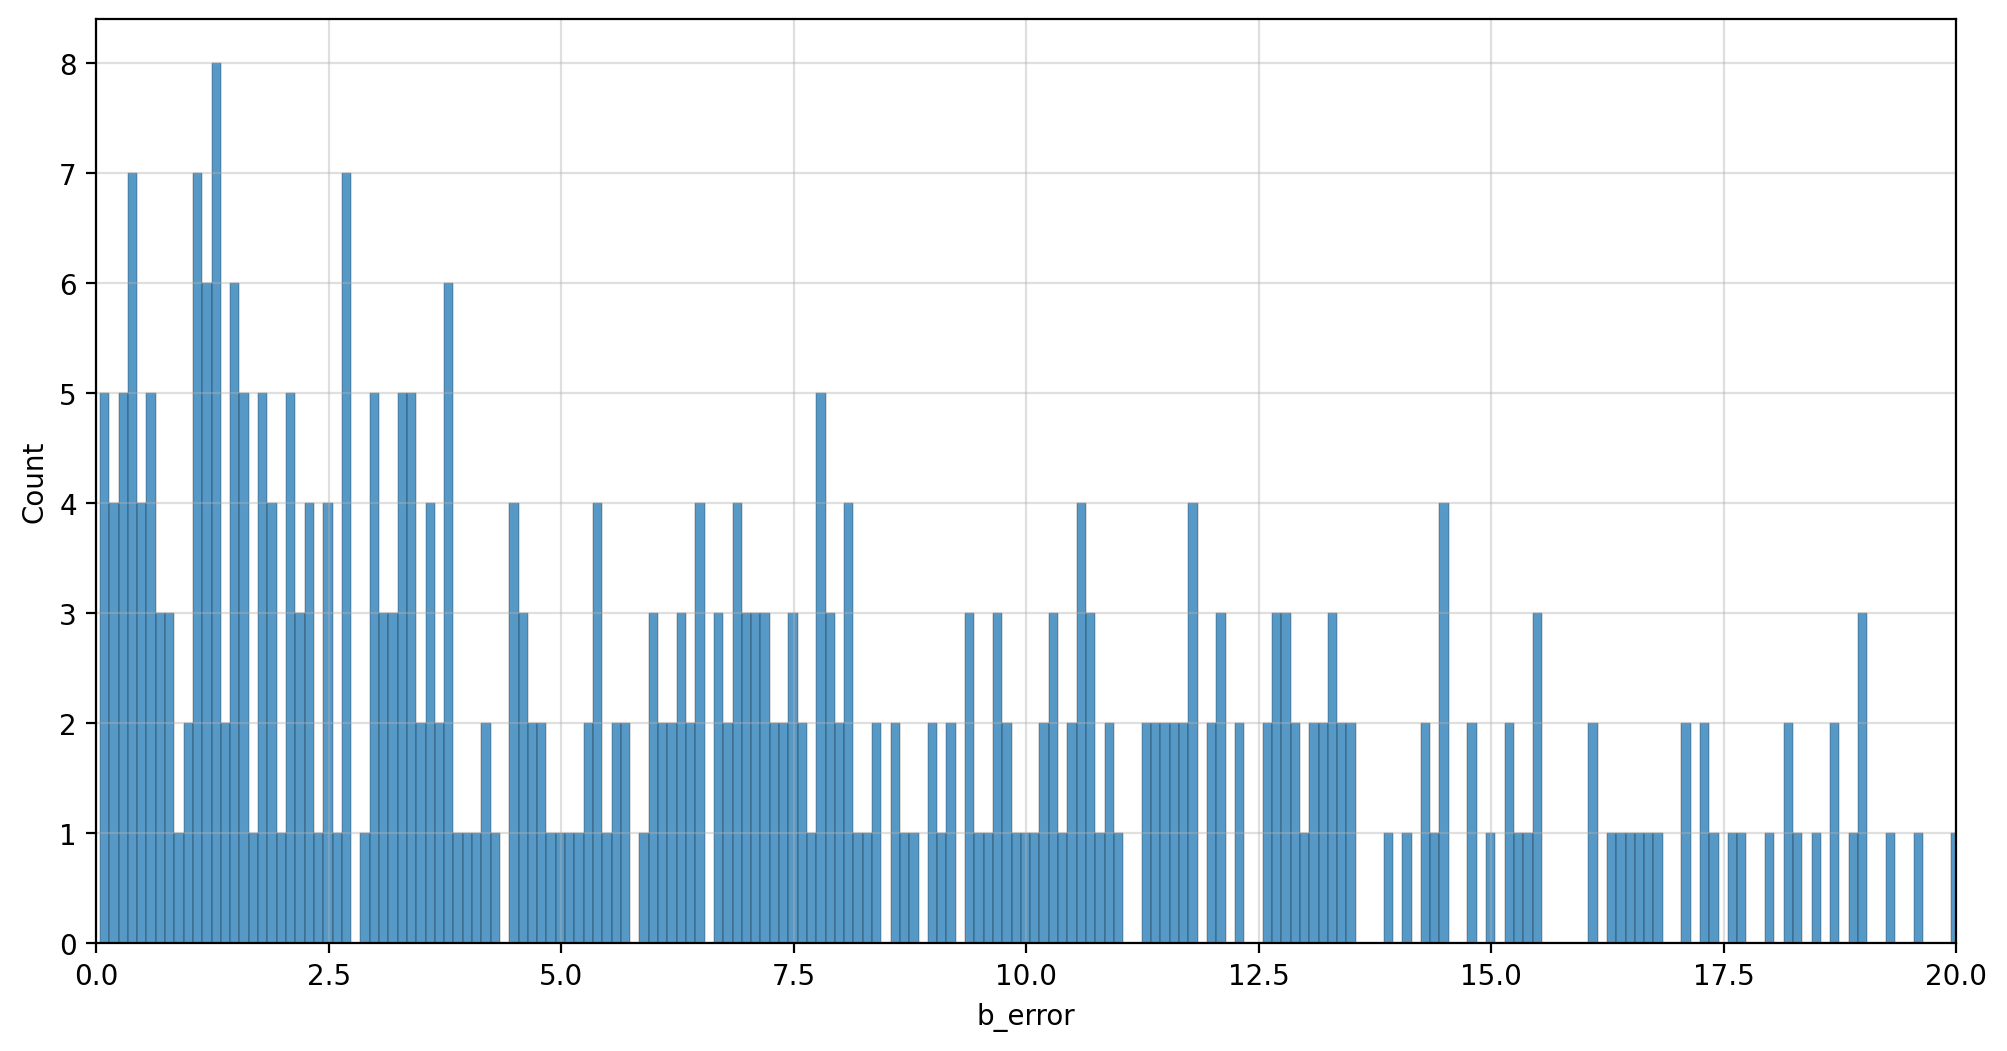

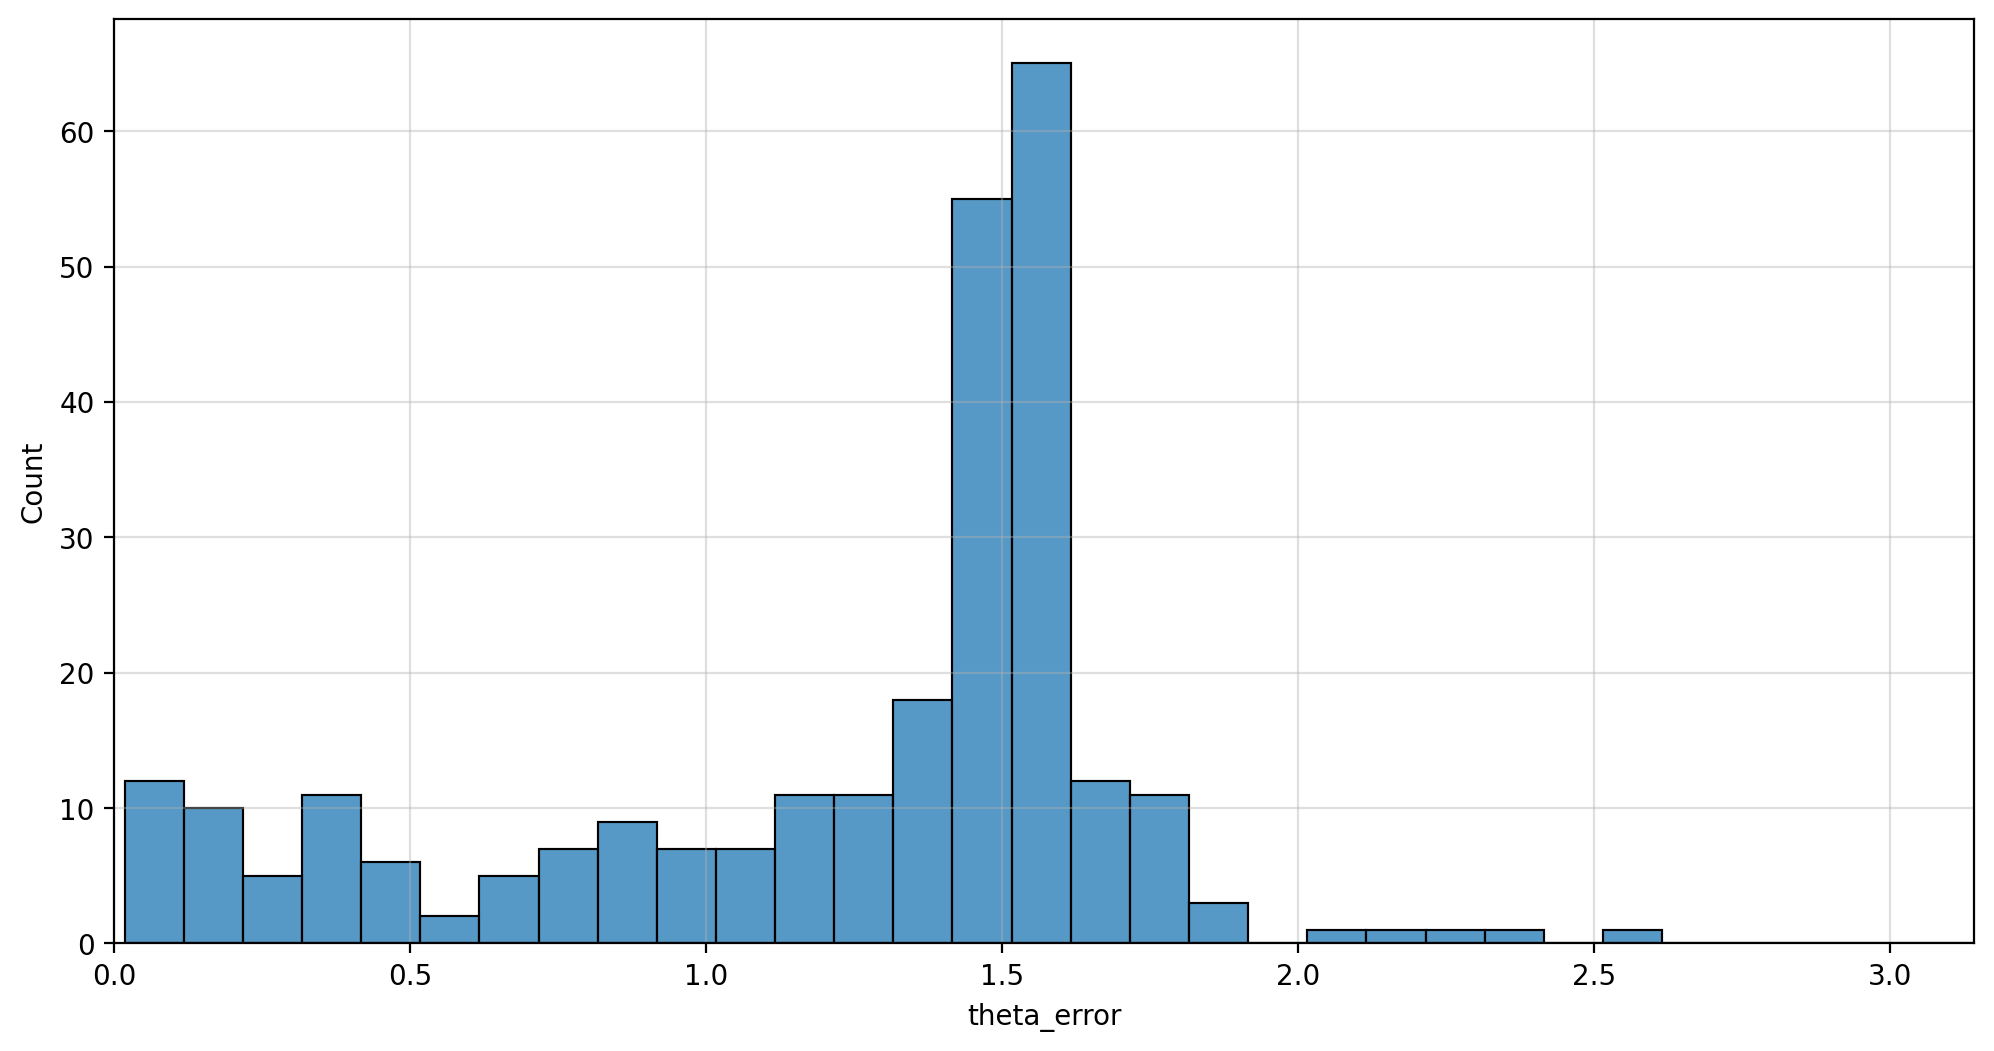

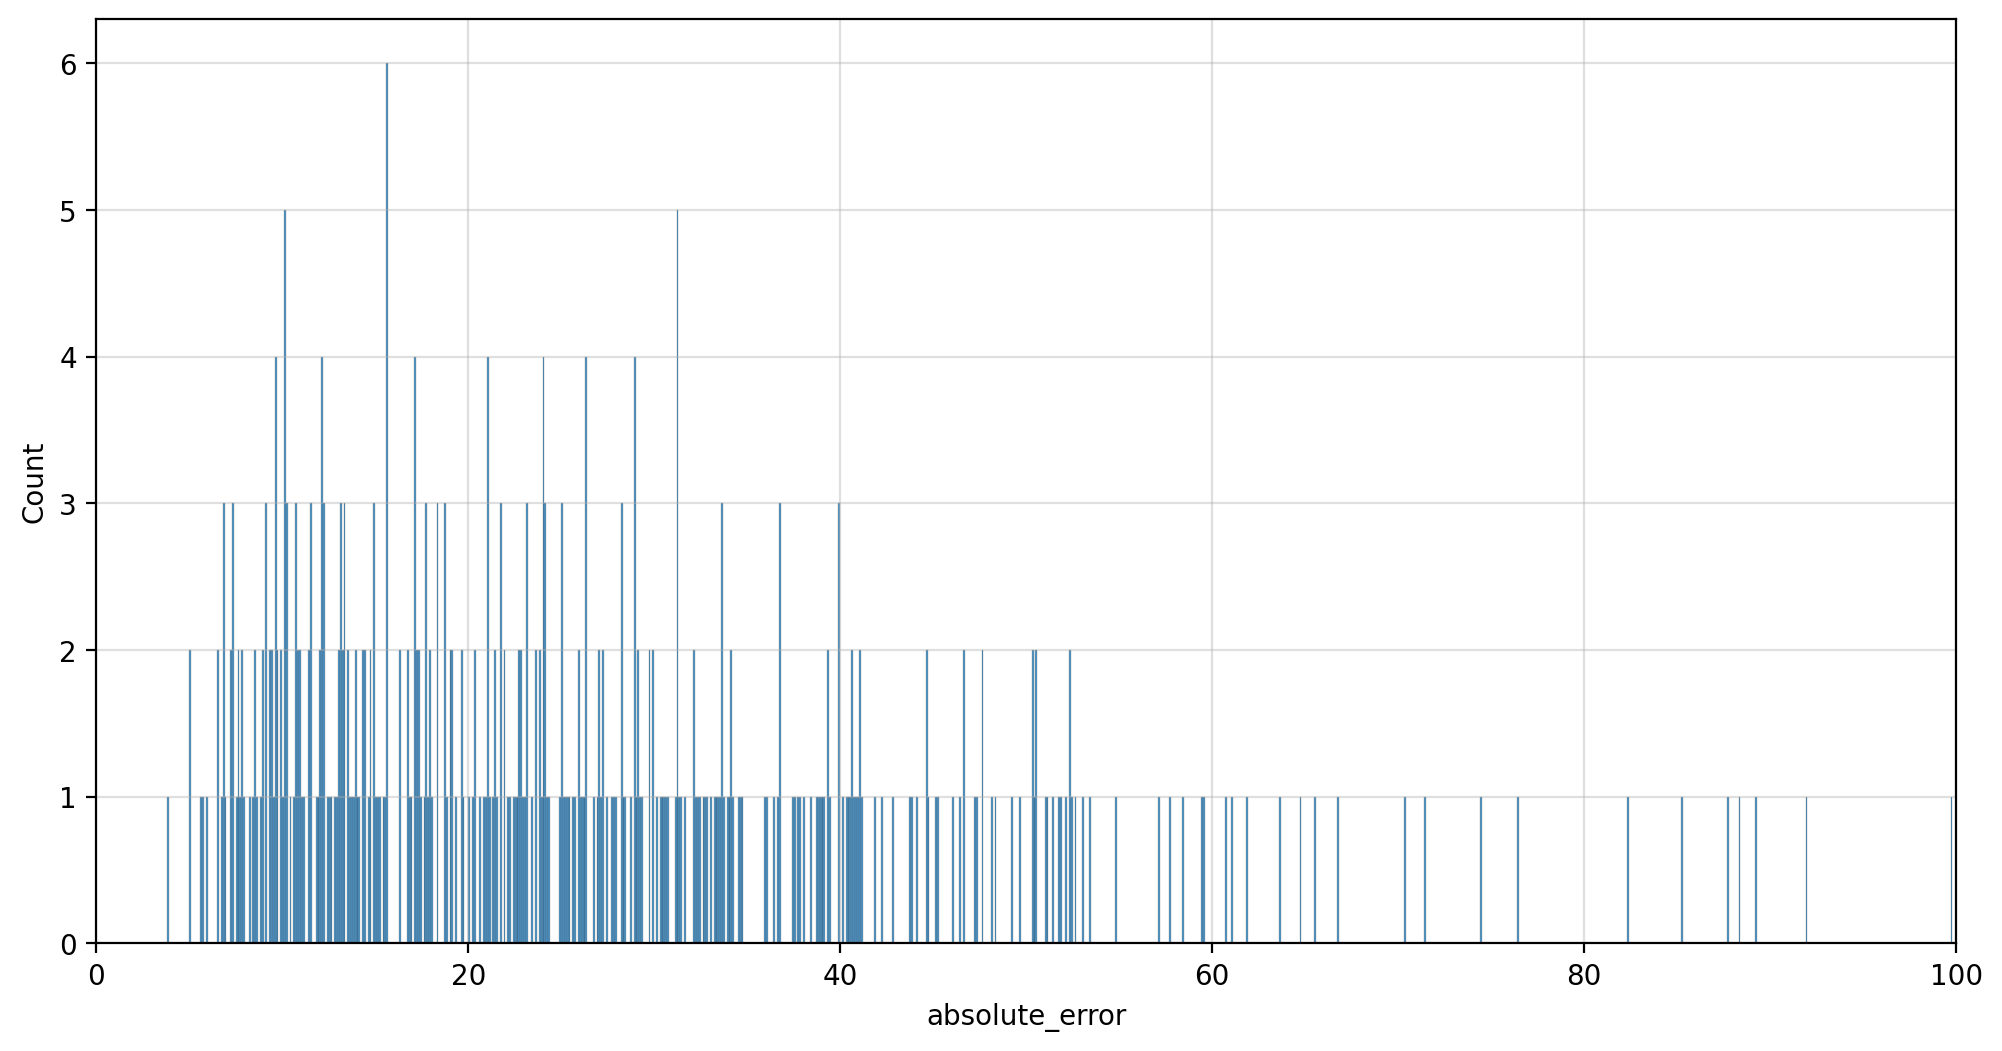

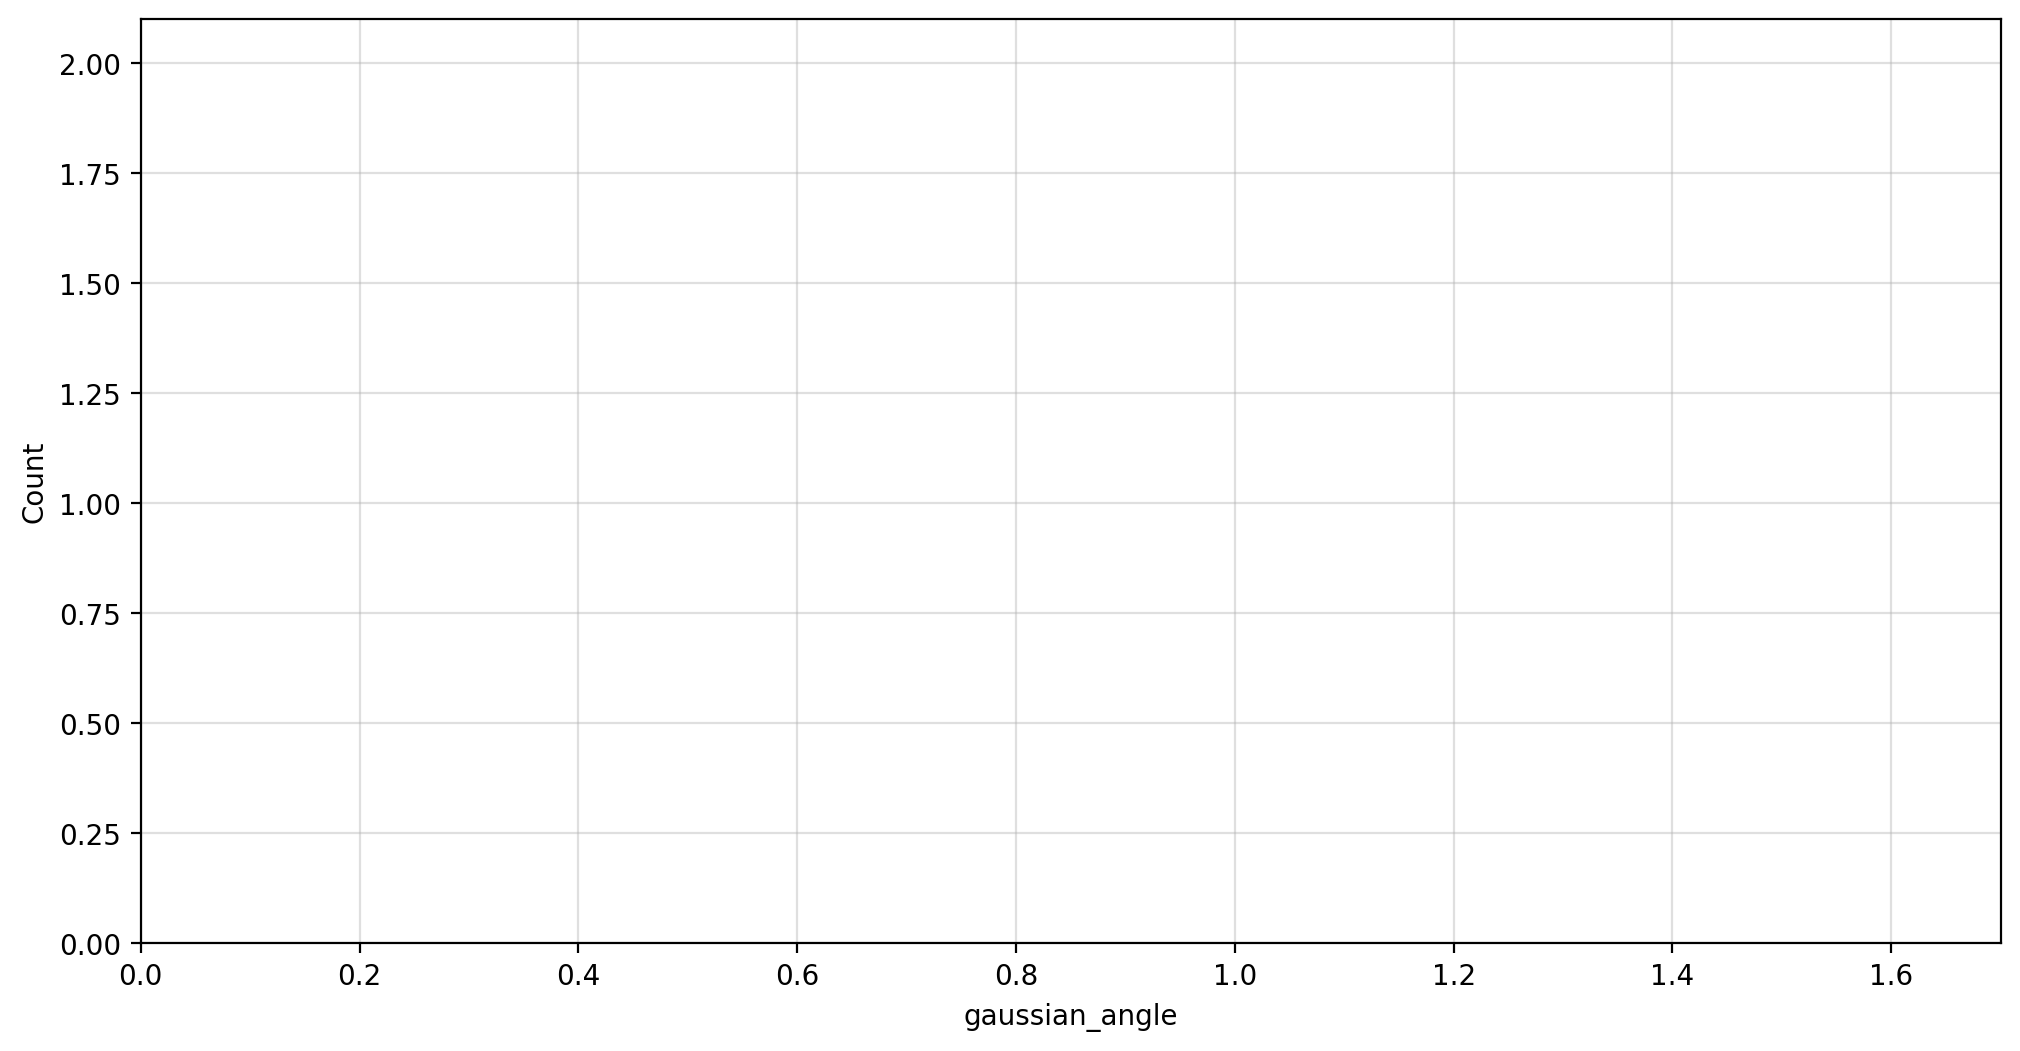

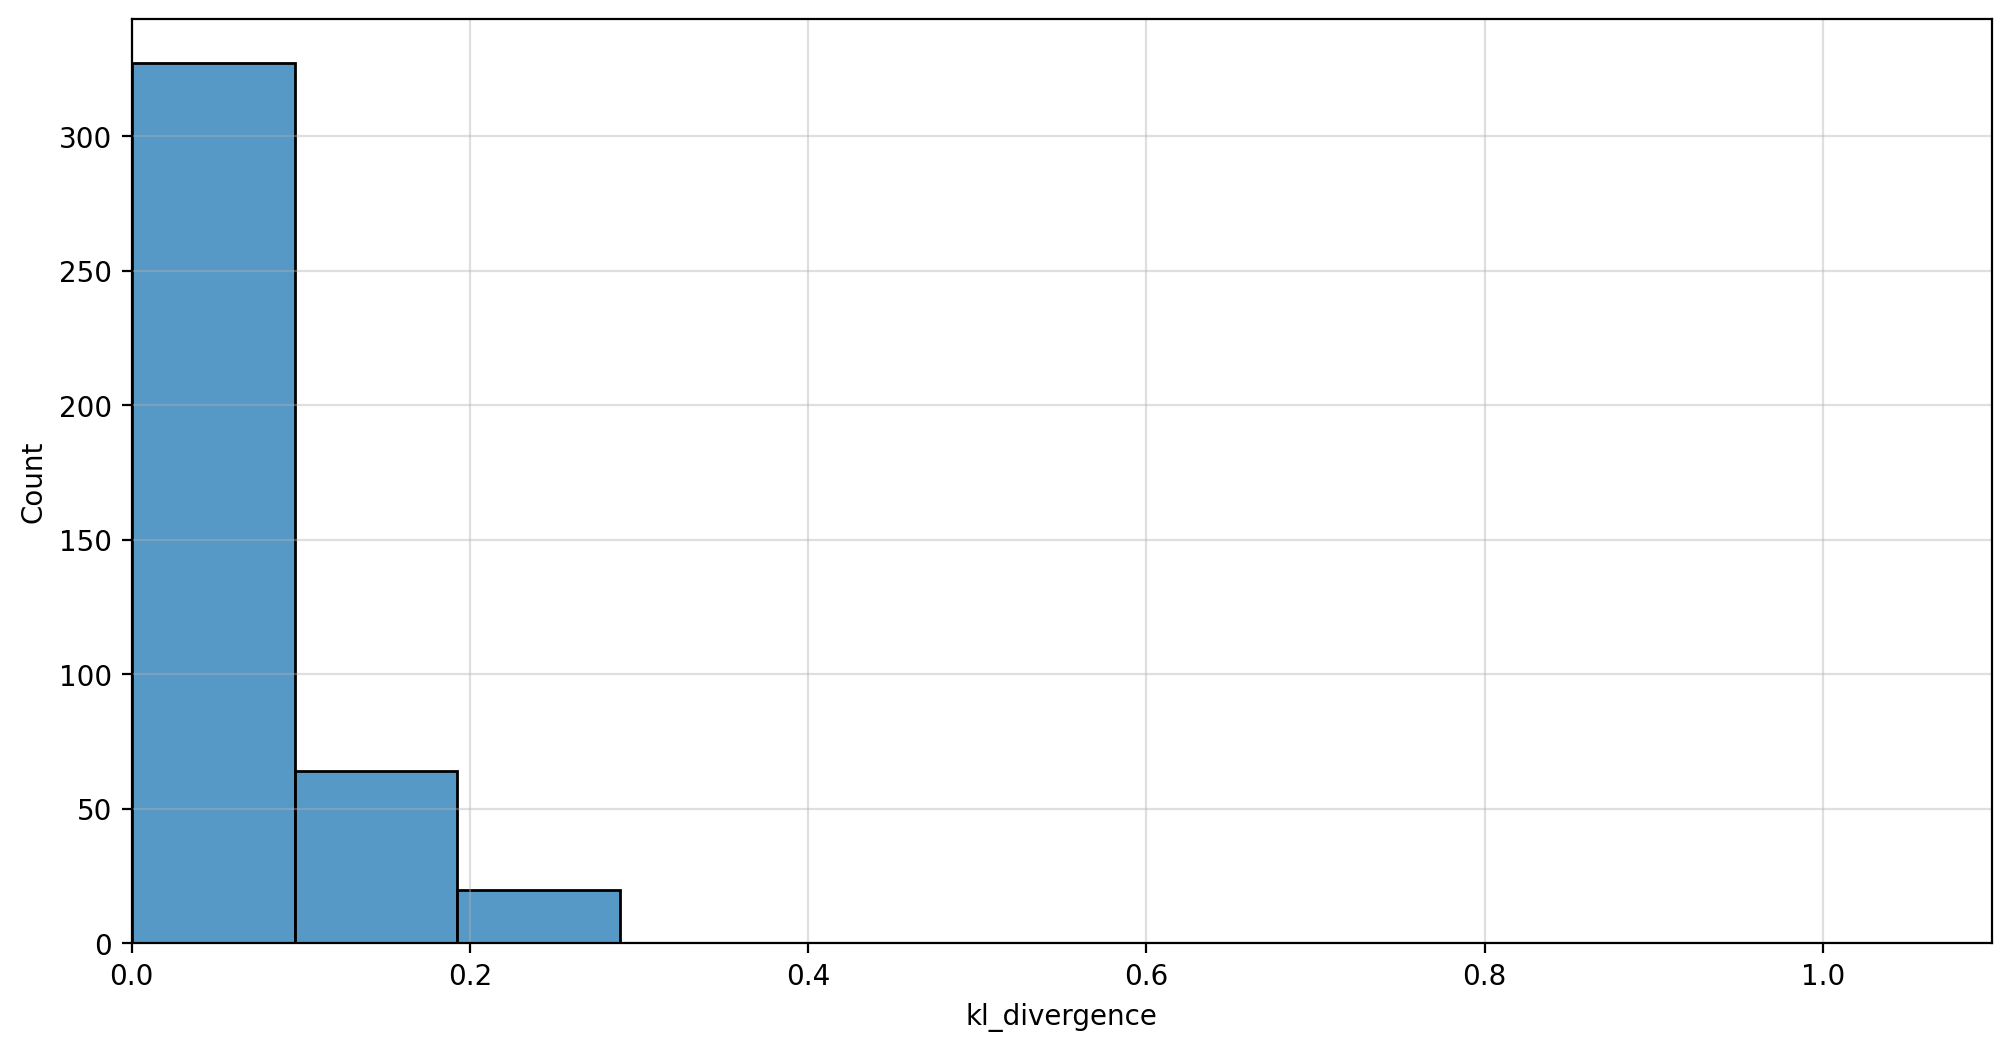

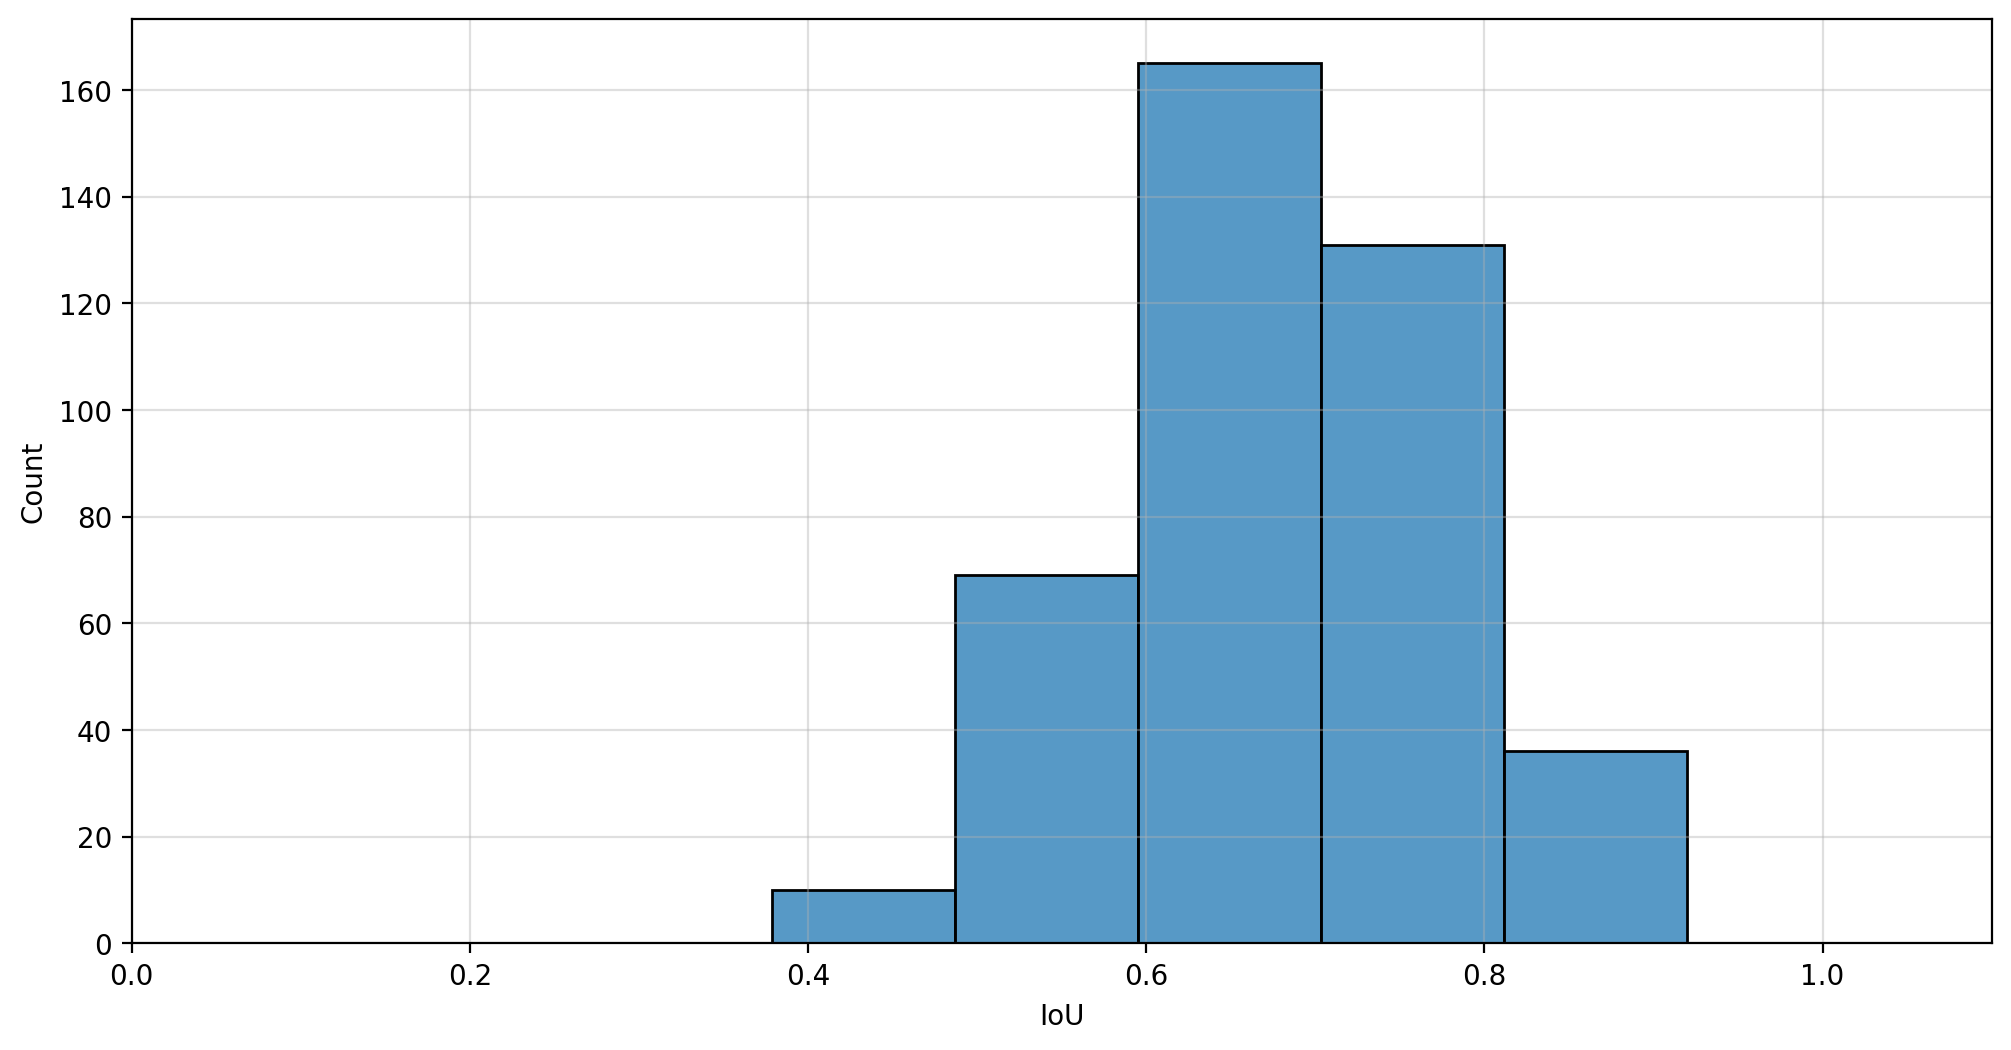

In [37]:
keys = [ 'x_error', 'y_error', 'a_error', 'b_error', 'theta_error', 'absolute_error','gaussian_angle', 'kl_divergence', 'IoU' ]
bin_widths = [ 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, ]
xlims = [ 20, 20, 20, 20, math.pi, 100, 1.7, 1.1, 1.1 ]
print(ellipse_matches.keys())
for i, key in enumerate( keys ):
    p = sns.histplot(
        data = ellipse_matches,
        x = key,
        binwidth = bin_widths[i],
    )
    p.set_xlim( 0, xlims[i] )
    p.grid( alpha = 0.4 )
    plt.show()

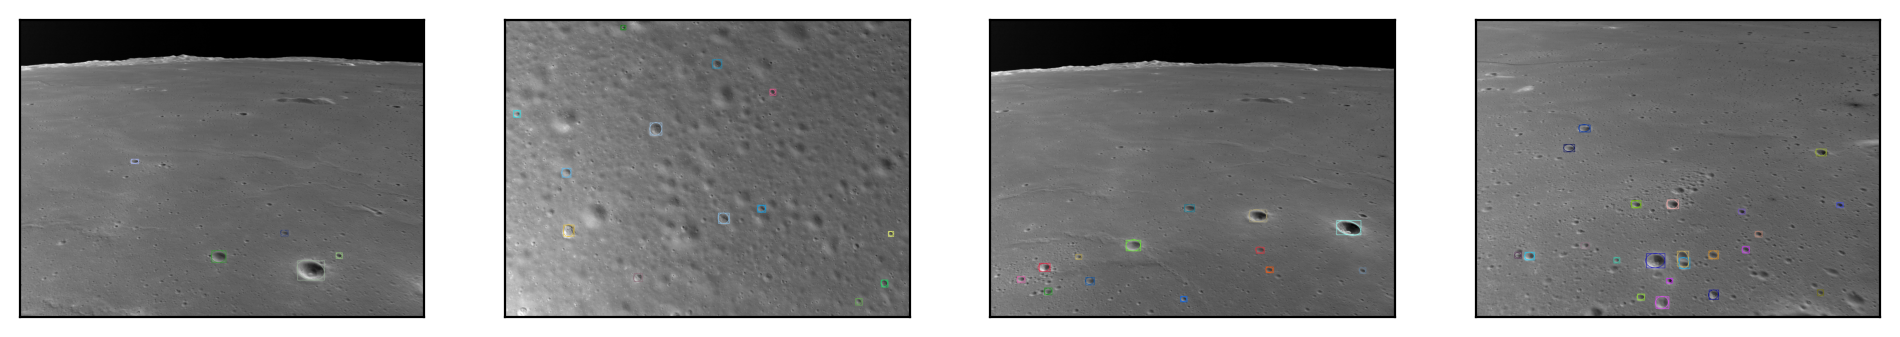

In [62]:
# Show a random sample of images
n_samples = 4
fig, ax = plt.subplots( ncols = n_samples )

for i in range( n_samples ):
    pred_index = int( np.random.rand() * len( predictions ) )
    img, target = dataset_test.__getitem__( pred_index )
    img = img.numpy()[0]
    img = np.stack( ( img, img, img ), axis = 2 )

    for bbox, ellipse in zip( predictions[pred_index]['boxes'], predictions[pred_index]['ellipse_sparse'] ):
        color = ( np.random.rand(), np.random.rand(), np.random.rand() )
        # Plot bounding box:
        cv2.rectangle(
            img,
            ( int( bbox[0] ), int( bbox[1] ) ),
            ( int( bbox[2] ), int( bbox[3] ) ),
            color,
            2,
        )

        # Plot ellipse:
        cv2.ellipse(
            img,
            ( int( ellipse[0] ), int( ellipse[1] ) ), # Center point
            ( int( ellipse[2] ), int( ellipse[3] ) ), # Major and minor axes
            float( ellipse[4] * 180 / math.pi ), # Convert angle from radians to degrees
            0, # Start Angle for drawing
            360, # End Angle for drawing
            color,
            2,
        )

    ax[i].imshow( img )
    ax[i].set_xticks( [] )
    ax[i].set_yticks( [] )
    # ax[i].set_title( 'Angle: {angle:d}, Sample: {sample:d}'.format( angle = target['view_angle'][0].item(), sample = target['image_id'].item() ) )
plt.show()